# Assignment 6 - SINDy autoencoders

Team members: Agata Kaczmarek (uni-id), Mateusz Stączek (uni-id)

In [ ]:
import numpy as np
from scipy.integrate import odeint
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import pandas as pd
from torch.nn import functional as F
np.random.seed(123)

from sklearn import linear_model
from functools import partial
from sklearn.model_selection import train_test_split
import copy

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Task 1 - SINDy in Ground Truth Coordinates $z$

## Task 1.1 - Simulation

In [ ]:
def pendulum_rhs(zt, dzt, coefficients, terms):
    """Computes the scalar product theta(z, zt)*coefficients 
    between the function terms and the coefficients at the given time points (zt, dzt)
    
    Args:
        zt, dzt: vectors of time points
        coefficients: for terms in the scalar product
        terms: one function terms theta(zt, dzt)
    """
    if np.isscalar(zt):
        term_values=[]
        for function in terms:
            term_value = function(zt, dzt)
            term_values.append(term_value)
        output = np.sum(term_values*coefficients, axis = -1)
        return output
    if isinstance(zt, list):
        zt = np.asarray(zt)
    if isinstance(dzt, list):
        dzt = np.asarray(dzt)
    if isinstance(coefficients, list):
        coefficients = np.asarray(coefficients)
    derivative=[]
    if zt.shape != dzt.shape:
        raise ValueError("Wrong shape. zt and dzt has to have the same shape.")
    for i in range(zt.shape[0]):
        term_values=[]
        for function in terms:
            term_value = function(zt[i], dzt[i])
            term_values.append(term_value)
        if isinstance(coefficients, np.ndarray):
            output = np.sum(term_values*coefficients, axis = -1)
        else:
            output = torch.matmul(torch.Tensor(term_values),coefficients)
        derivative.append(output)
    return derivative

Check the above function

In [ ]:
zt = np.array([1.0, 2.0, 3.0])
dzt = np.array([0.5, 1.0, 1.5])
coefficients = ([2.0, -1.0, 3.0])
def my_function(z, dz):
    return z+dz
print(pendulum_rhs(zt, dzt, coefficients, [my_function, my_function, my_function]))

[6.0, 12.0, 18.0]


In [ ]:
def pendulum_ode_step(y, t, coefficients, terms):
    """to be used as the func parameter to scipy.integrate.odeint"""
    zt, dzt = y
    ddzt = pendulum_rhs(zt, dzt, coefficients, terms)
    return [dzt, ddzt] 

In [ ]:
def sin_function(z, dz):
    return np.sin(z)

def cos_function(z, dz):
    return -np.cos(z)

Check if the odeint is able to use our function.

In [ ]:
terms = [sin_function, cos_function]
t_val = np.linspace(0,10, 5)
y_init = [0.1, 0.2]
coeff_val = np.array([1.0, 1.0])
res = odeint(pendulum_ode_step, y_init, t_val, args=(coeff_val, terms))
res

array([[ 0.1       ,  0.2       ],
       [-2.64047528, -2.22364092],
       [-4.73205762,  0.43672333],
       [-0.730558  ,  1.44036162],
       [-0.5691254 , -1.27386066]])

In [ ]:
def simulate_pendulum(z0, dz0, coefficients, terms, T, dt):
    t_val = np.arange(0, T*dt, dt)
    result = odeint(pendulum_ode_step, [z0, dz0], t_val, args=(coefficients, terms))
    return result

Simulate data

In [ ]:
result = simulate_pendulum(0.1, 0.2, coeff_val, terms, 100, 0.1)
result

array([[ 0.1       ,  0.2       ],
       [ 0.11555668,  0.11141947],
       [ 0.12232504,  0.02407314],
       [ 0.12038025, -0.06300509],
       [ 0.10970067, -0.15078393],
       [ 0.09016804, -0.24022515],
       [ 0.06156874, -0.33227246],
       [ 0.02359628, -0.42783611],
       [-0.02414427, -0.52777069],
       [-0.08212925, -0.63284315],
       [-0.15090549, -0.74368756],
       [-0.2310741 , -0.86074363],
       [-0.32326716, -0.98417591],
       [-0.42811529, -1.11377257],
       [-0.54620424, -1.24882561],
       [-0.67801864, -1.38799978],
       [-0.8238729 , -1.52920616],
       [-0.98383066, -1.66950632],
       [-1.15761768, -1.80508418],
       [-1.34453709, -1.93132937],
       [-1.54340034, -2.04307122],
       [-1.75248988, -2.13498116],
       [-1.96956973, -2.2021189 ],
       [-2.19195483, -2.24054453],
       [-2.4166399 , -2.24787375],
       [-2.64047523, -2.22364094],
       [-2.86036489, -2.16937236],
       [-3.07345643, -2.08834894],
       [-3.27729388,

In [ ]:
def create_pendulum_data(z0_min, z0_max, dz0_min, dz0_max, coefficients, 
                         terms, T, dt, N, embedding=None, rejection=True):
    output_matrix = np.zeros((N, T, 3))
    for n in range(N):
        z0 = np.random.uniform(z0_min, z0_max)
        dz0 = np.random.uniform(dz0_min, dz0_max)
        if rejection:
            while abs(1/2*dz0**2-np.cos(z0))>0.99:
                z0 = np.random.uniform(z0_min, z0_max)
                dz0 = np.random.uniform(dz0_min, dz0_max)
        result = simulate_pendulum(z0, dz0, coefficients, terms, T, dt)  
        for i in range(len(result)):
            second = pendulum_rhs(result[i][0], result[i][1], np.array([-1.0]), [sin_function])
            output_matrix[n][i][0]=result[i][0]
            output_matrix[n][i][1]=result[i][1]
            output_matrix[n][i][2]=second

    return output_matrix
    

Create all training data and plot them

In [ ]:
terms = [sin_function]
coeff_val = np.array([-1.0])
training_data = create_pendulum_data(-np.pi, np.pi, -2.1, 2.1, coeff_val, 
                         terms, 500, 0.02, 100, embedding=None, rejection=True)

In [ ]:
def plot_function(training_data, num_to_plot, title="5 Simulations of Pendulum data\nangle z and its derivatives"):
    for j in range(num_to_plot):
        z0_to_plot=[]
        dz0_to_plot=[]
        ddz0_to_plot=[]
        for i in range(len(training_data[0])):
            z0_to_plot.append(training_data[j][i][0])
            dz0_to_plot.append(training_data[j][i][1])
            ddz0_to_plot.append(training_data[j][i][2])

        plt.plot(range(len(ddz0_to_plot)), ddz0_to_plot, label=f"ddzt{j}")
        plt.plot(range(len(dz0_to_plot)), dz0_to_plot, label=f"dzt{0}")
        plt.plot(range(len(z0_to_plot)), z0_to_plot, label=f"zt{0}")

    plt.legend()
    plt.title(title)
    plt.show()

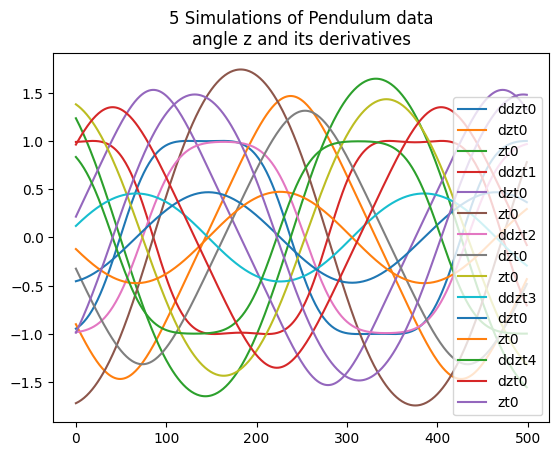

In [ ]:
plot_function(training_data, 5)

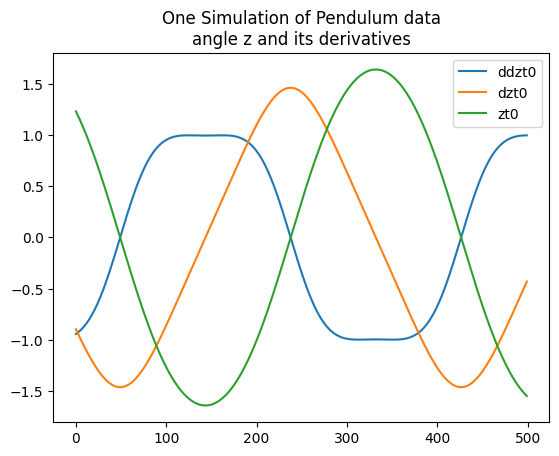

In [ ]:
plot_function(training_data, 1, title="One Simulation of Pendulum data\nangle z and its derivatives")

<div style="color: green; font-weight: bold">
Comment - ok:

* pendulum_rhs is implemented differently than in the sample solution, but our implementation is a valid alternative
* pendulum_ode_step ok
* simulate_pendulum ok, but in sample solution it is adapted to y vectors, our not
* create_pendulum_data ok
* plots are similar to what we see in sample solution
* we did not provide animations, but they were optional

</div>

## Task 1.2 - Implementation & Training

In [ ]:
def f1(z, dz):
    return 1

def f2(z, dz):
    return z

def f3(z, dz):
    return dz

def f4(z, dz):
    if isinstance(z, torch.Tensor):
        return torch.sin(z)
    else:
        return np.sin(z)

def f5(z, dz):
    return z**2

def f6(z, dz):
    return z*dz

def f7(z, dz):
    if isinstance(z, torch.Tensor):
        return z*torch.sin(z)
    else:
        return z*np.sin(z)

def f8(z, dz):
    return dz**2

def f9(z, dz):
    if isinstance(z, torch.Tensor):
        return dz*torch.sin(z)
    else:
        return dz*np.sin(z)

def f10(z, dz):
    if isinstance(z, torch.Tensor):
        return torch.sin(z)*torch.sin(z)
    else:
        return np.sin(z)*np.sin(z)

In [ ]:
theta=[f1, f2, f3, f4, f5, f6, f7, f8, f9, f10]

### LASSO version

LASSO will find optimal coefficients to 10 basis functions. For this reason, we need to precompute outputs of each of the basis functions for each of the training samples which then will be used as input to LASSO. 

In [ ]:
def prepare_data_for_lasso(training_data, theta):
    z_dot_dot_list=[]
    theta_results_list=[]

    for T in range(len(training_data)):
        for N in range(len(training_data[0])):
            term_values=[]
            for function in theta:
                term_value = function(training_data[T][N][0], training_data[T][N][1])
                term_values.append(term_value)
            theta_results_list.append(term_values)
            z_dot_dot_list.append(training_data[T][N][2])
    
    z_dot_dot=np.asarray(z_dot_dot_list)
    theta_results=np.asarray(theta_results_list)

    return z_dot_dot, theta_results

In [ ]:
z_dot_dot, theta_results = prepare_data_for_lasso(training_data, theta)

In [ ]:
clf = linear_model.Lasso(alpha=0.1)
clf.fit(theta_results, z_dot_dot)
lasso_coef=clf.coef_
lasso_coef

array([ 0.        , -0.21119086, -0.        , -0.47282279,  0.        ,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ])

Here, according to Lasso model, function $sin(z)$ has the biggest absolute value, but also function $z$ has value significantly different than 0.

### pytorch version

which uses ADAM optimizer

In [ ]:
class SINDy(nn.Module):
    def __init__(self, coefficients, mask, terms):
        super(SINDy, self).__init__()
        self.coefficients = torch.nn.Parameter(torch.Tensor(coefficients))
        self.mask = torch.Tensor(mask)
        self.terms = terms
        
    def forward(self, z, dz):
        return torch.Tensor(pendulum_rhs(z, dz, torch.multiply(self.coefficients,self.mask), self.terms))

In [ ]:
def SINDy_loss(ddz, ddz_hat, lambda_param, coefficients):
    residuals = ddz - ddz_hat
    loss = torch.mean(torch.norm(residuals, p=2, dim=-1)**2) + lambda_param*torch.norm(coefficients, p=1)
    return loss

In [ ]:
def train_sindy(model, 
                z_train, z_test, 
                dz_train, dz_test,
                y_train, y_test, 
                n_epochs, batch_size, 
                learning_rate=0.001,
                print_logs=True,
                lambda_param = 0.1):
    """
    Args:
        model - SINDy model
        z_train, z_test - z data for model
        dz_train, dz_test - dz data for model
        y_train, y_test - expected output of the model
        n_epochs - number of epochs
        batch_size - batch size
        learning_rate - learning rate
        lambda_param - regularization parameter
    """

    loss_function = partial(SINDy_loss, lambda_param=lambda_param, coefficients=model.coefficients)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []
    
    z_train = torch.from_numpy(z_train).float()
    z_test = torch.from_numpy(z_test).float()
    dz_train = torch.from_numpy(dz_train).float()
    dz_test = torch.from_numpy(dz_test).float()
    y_train = torch.from_numpy(y_train).float()
    y_test = torch.from_numpy(y_test).float()

    # loss before training
    with torch.no_grad():
        loss = loss_function(y_train, model(z_train, dz_train))
        train_losses.append(loss.item())
        loss = loss_function(y_test, model(z_test, dz_test))
        test_losses.append(loss.item())
    if print_logs:
        print(f"Epoch 0/{n_epochs}: train_loss={train_losses[-1]:.4f}, test_loss={test_losses[-1]:.4f}, coefficients={model.coefficients.data}.")

    coefficients_list=[[] for _ in range(n_epochs)]
    # training
    for epoch in range(n_epochs):
        train_loss = 0
        test_loss = 0
        for i in range(0, len(z_train), batch_size):
            z_batch = z_train[i:i+batch_size]
            dz_batch = dz_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            optimizer.zero_grad()
            loss = loss_function(y_batch, model(z_batch, dz_batch))
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(z_batch)
        train_loss /= len(z_train)
        train_losses.append(train_loss)

        with torch.no_grad():
            for i in range(0, len(z_test), batch_size):
                z_batch = z_test[i:i+batch_size]
                dz_batch = dz_test[i:i+batch_size]
                y_batch = y_test[i:i+batch_size]
                loss = loss_function(y_batch, model(z_batch, dz_batch))
                test_loss += loss.item() * len(z_batch)
            test_loss /= len(z_test)
            test_losses.append(test_loss)
        coefficients_list[epoch]=copy.deepcopy(model.coefficients.data)
        if (epoch+1) % (n_epochs//10+1) == 0 or epoch == n_epochs-1:
            if print_logs:
                print(f"Epoch {epoch+1}/{n_epochs}: train_loss={train_loss:.4f}, test_loss={test_loss:.4f}, coefficients={model.coefficients.data}.")
    df = pd.DataFrame({'train': train_losses, 'test': test_losses, 'epoch': list(range(n_epochs+1))})
    return df, coefficients_list

In [ ]:
def divide_into_train_and_test(training_data):

    train_data, test_data = train_test_split(training_data , 
                                    random_state=104,  
                                    test_size=0.25,  
                                    shuffle=True)

    z_train=[]
    dz_train=[]
    ddz_train=[]

    for T in range(len(train_data)):
        for N in range(len(train_data[0])):
            z_train.append(train_data[T][N][0])
            dz_train.append(train_data[T][N][1])
            ddz_train.append(train_data[T][N][2])

    z_train=np.asarray(z_train)
    dz_train=np.asarray(dz_train)
    ddz_train=np.asarray(ddz_train)

    z_test=[]
    dz_test=[]
    ddz_test=[]

    for T in range(len(test_data)):
        for N in range(len(test_data[0])):
            z_test.append(test_data[T][N][0])
            dz_test.append(test_data[T][N][1])
            ddz_test.append(test_data[T][N][2])

    z_test=np.asarray(z_test)
    dz_test=np.asarray(dz_test)
    ddz_test=np.asarray(ddz_test)

    return z_train, dz_train, ddz_train, z_test, dz_test, ddz_test

In [ ]:
z_train, dz_train, ddz_train, z_test, dz_test, ddz_test = divide_into_train_and_test(training_data)

In [ ]:
coefficients = np.ones(len(theta))
mask = np.ones(len(theta))
sindy_model = SINDy(coefficients, mask, theta)

df_result_1_2, coef_1_2=train_sindy(sindy_model, 
            z_train, z_test, 
            dz_train, dz_test,
            ddz_train, ddz_test, 
            n_epochs=4, batch_size=64, 
            learning_rate=0.001,
            print_logs=True,
            lambda_param = 0.1)

Epoch 0/4: train_loss=1534430.8750, test_loss=450609.2812, coefficients=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]).
Epoch 1/4: train_loss=1471.2561, test_loss=461.7492, coefficients=tensor([0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140,
        0.4140]).
Epoch 2/4: train_loss=163.5772, test_loss=30.7062, coefficients=tensor([-0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002,
        -0.0002, -0.0002]).
Epoch 3/4: train_loss=34.8958, test_loss=30.7958, coefficients=tensor([0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0003]).
Epoch 4/4: train_loss=34.9030, test_loss=30.8282, coefficients=tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005]).


In [ ]:
print(f"Coefficients from model SINDy: {sindy_model.coefficients.data}.")
print(f"Coefficients from LASSO: {lasso_coef}.")

Coefficients from model SINDy: tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005]).
Coefficients from LASSO: [ 0.         -0.21119086 -0.         -0.47282279  0.         -0.
  0.          0.         -0.          0.        ].


For SINDy model all basis functions seems to be equally important. For LASSO - as before, the results shown here are the ones generated above.

<div style="color: green; font-weight: bold">
Comment - part the same and correct, part different and wrong:

* for sklearn Lasso method we have similar implementation, the only difference is that we have different values of parameters for this sklearn method. Next time we should try out more parameters settings, so the results could be more meaningful, as in the sample solution.
* for PyTorch implementation: in our implementation we used different loss function than MSE. Our approach did not give great results, this is probably the reason for that. This mistake here probably caused problems in following parts of the whole assignment. Other parts of the implementation in this subsection look similar.

</div>

## Task 1.3 - Thresholding

In [ ]:
def train_sindy_1_3(model, 
                z_train, z_test, 
                dz_train, dz_test,
                y_train, y_test, 
                n_epochs, batch_size, 
                learning_rate=0.001,
                print_logs=True,
                lambda_param = 0.1,
                thresholding=None,
                threshold_a=0, 
                threshold_b=0, 
                interval_or_patience=10):
    """
    Args:
        model - SINDy model
        z_train, z_test - z data for model
        dz_train, dz_test - dz data for model
        y_train, y_test - expected output of the model
        n_epochs - number of epochs
        batch_size - batch size
        learning_rate - learning rate
        lambda_param - regularization parameter
        thresholdig - which thresholding method should be applied
        threshold_a, threshold_b, interval_or_patience - parameters depending if ST or PTAT

    """

    loss_function = partial(SINDy_loss, lambda_param=lambda_param, coefficients=model.coefficients)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []
    
    z_train = torch.from_numpy(z_train).float()
    z_test = torch.from_numpy(z_test).float()
    dz_train = torch.from_numpy(dz_train).float()
    dz_test = torch.from_numpy(dz_test).float()
    y_train = torch.from_numpy(y_train).float()
    y_test = torch.from_numpy(y_test).float()

    # loss before training
    with torch.no_grad():
        loss = loss_function(y_train, model(z_train, dz_train))
        train_losses.append(loss.item())
        loss = loss_function(y_test, model(z_test, dz_test))
        test_losses.append(loss.item())
    if print_logs:
        print(f"Epoch 0/{n_epochs}: train_loss={train_losses[-1]:.4f}, test_loss={test_losses[-1]:.4f}, coefficients={model.coefficients.data}.")

    coefficients_prev = torch.zeros(model.coefficients.data.shape[0])
    Ea=np.zeros(model.coefficients.data.shape[0])
    Eb=np.zeros(model.coefficients.data.shape[0])

    coefficients_list=[]
    # training
    for epoch in range(n_epochs):

        if thresholding=="sequential":
            if (epoch) % interval_or_patience == 0:
                mask_y = torch.abs(model.coefficients.data)<threshold_a
                model.coefficients.data[mask_y]=0
                model.mask[mask_y]=0 #False

        elif thresholding=="patient":
            mask_a = torch.abs(model.coefficients.data) > threshold_a
            mask_b = torch.abs(model.coefficients.data- coefficients_prev) > threshold_b

            Ea[mask_a]=epoch
            Eb[mask_b]=epoch

            mask_trend_aware = ((epoch - Ea)<interval_or_patience) | ((epoch - Eb)<interval_or_patience)
            model.mask = model.mask * mask_trend_aware

            coefficients_prev = model.coefficients.data.clone()

        train_loss = 0
        test_loss = 0
        for i in range(0, len(z_train), batch_size):
            z_batch = z_train[i:i+batch_size]
            dz_batch = dz_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            optimizer.zero_grad()
            loss = loss_function(y_batch, model(z_batch, dz_batch))
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(z_batch)
        train_loss /= len(z_train)
        train_losses.append(train_loss)

        with torch.no_grad():
            for i in range(0, len(z_test), batch_size):
                z_batch = z_test[i:i+batch_size]
                dz_batch = dz_test[i:i+batch_size]
                y_batch = y_test[i:i+batch_size]
                loss = loss_function(y_batch, model(z_batch, dz_batch))
                test_loss += loss.item() * len(z_batch)
            test_loss /= len(z_test)
            test_losses.append(test_loss)
        coefficients_list.append(copy.deepcopy(model.coefficients.data))
        if (epoch+1) % (n_epochs//10+1) == 0 or epoch == n_epochs-1:
            if print_logs:
                print(f"Epoch {epoch+1}/{n_epochs}: train_loss={train_loss:.4f}, test_loss={test_loss:.4f}, coefficients={model.coefficients.data}.")
    df = pd.DataFrame({'train': train_losses, 'test': test_losses, 'epoch': list(range(n_epochs+1))})
    return df, coefficients_list

In [ ]:
coefficients = np.ones(len(theta))
mask = np.ones(len(theta))
sindy_model_1_3_1 = SINDy(coefficients, mask, theta)
df_result_1_3_1, coef_1_3_1=train_sindy_1_3(sindy_model_1_3_1, 
            z_train, z_test, 
            dz_train, dz_test,
            ddz_train, ddz_test, 
            n_epochs=4, batch_size=64, 
            learning_rate=0.001,
            print_logs=True,
            lambda_param = 0.1)

Epoch 0/4: train_loss=1534430.8750, test_loss=450609.1875, coefficients=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]).
Epoch 1/4: train_loss=1471.2561, test_loss=461.7492, coefficients=tensor([0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140,
        0.4140]).
Epoch 2/4: train_loss=163.5767, test_loss=30.7060, coefficients=tensor([-0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002,
        -0.0002, -0.0002]).
Epoch 3/4: train_loss=34.8954, test_loss=30.7955, coefficients=tensor([0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0003]).
Epoch 4/4: train_loss=34.9027, test_loss=30.8279, coefficients=tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005]).


In [ ]:
coefficients = np.ones(len(theta))
mask = np.ones(len(theta))
sindy_model_1_3_2 = SINDy(coefficients, mask, theta)

df_result_1_3_2, coef_1_3_2 = train_sindy_1_3(sindy_model_1_3_2, 
            z_train, z_test, 
            dz_train, dz_test,
            ddz_train, ddz_test, 
            n_epochs=4, batch_size=128, 
            learning_rate=0.001,
            print_logs=True,
            lambda_param = 0.1,
            thresholding="sequential",
            threshold_a=0.5, 
            threshold_b=0, 
            interval_or_patience=1)

Epoch 0/4: train_loss=1534430.8750, test_loss=450609.1875, coefficients=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]).
Epoch 1/4: train_loss=3965.0462, test_loss=2406.0906, coefficients=tensor([0.7070, 0.7070, 0.7070, 0.7070, 0.7070, 0.7070, 0.7070, 0.7070, 0.7070,
        0.7070]).
Epoch 2/4: train_loss=1850.1637, test_loss=923.0126, coefficients=tensor([0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140,
        0.4140]).
Epoch 3/4: train_loss=69.8080, test_loss=61.4734, coefficients=tensor([-0.0005, -0.0005, -0.0005, -0.0005, -0.0005, -0.0005, -0.0005, -0.0005,
        -0.0005, -0.0005]).
Epoch 4/4: train_loss=69.8076, test_loss=61.4729, coefficients=tensor([-4.6812e-05, -4.6812e-05, -4.6812e-05, -4.6812e-05, -4.6812e-05,
        -4.6812e-05, -4.6812e-05, -4.6812e-05, -4.6812e-05, -4.6812e-05]).


In [ ]:
coefficients = np.ones(len(theta))
mask = np.ones(len(theta))
sindy_model_1_3_3 = SINDy(coefficients, mask, theta)

df_result_1_3_3, coef_1_3_3 = train_sindy_1_3(sindy_model_1_3_3, 
            z_train, z_test, 
            dz_train, dz_test,
            ddz_train, ddz_test, 
            n_epochs=4, batch_size=64, 
            learning_rate=0.001,
            print_logs=True,
            lambda_param = 0.1,
            thresholding="patient",
            threshold_a=0.5, 
            threshold_b=0.7, 
            interval_or_patience=1)

Epoch 0/4: train_loss=1534430.8750, test_loss=450609.1875, coefficients=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]).
Epoch 1/4: train_loss=1471.2561, test_loss=461.7492, coefficients=tensor([0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140,
        0.4140]).
Epoch 2/4: train_loss=35.0492, test_loss=30.7453, coefficients=tensor([-0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002,
        -0.0002, -0.0002]).
Epoch 3/4: train_loss=34.9028, test_loss=30.7454, coefficients=tensor([0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0003]).
Epoch 4/4: train_loss=34.9028, test_loss=30.7456, coefficients=tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005]).


<div style="color: green; font-weight: bold">
Comment - similar:

* the general idea of implementation of thresholds is similar, code is different (e.g. in sample solution there are classes for Thresholders, in our solution no) but both work correct. Next time we should consider writing code that includes more classes, where it is useful and makes sense (as here).

</div>

## Task 1.4 - Evaluation & Visualization

### Comparison of loss and coefficients history

In [ ]:
def plot_loss_and_coefficients(loss_pd_df, coefficients):
    plt.plot(loss_pd_df['epoch'], loss_pd_df['train'], label='Training Loss')
    plt.plot(loss_pd_df['epoch'], loss_pd_df['test'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Changes in loss in time')
    plt.legend()
    plt.show()

    for i in range(len(coefficients)):
        coeff = coefficients[i]
        epochs_list=[i for _ in range(len(coeff))]
        plt.scatter(epochs_list, coeff, label=f'Epoch {i+1}')

    plt.xlabel('Epoch')
    plt.ylabel('Coefficient Value')
    plt.title('Changes in coefficient values in time')
    plt.legend()
    plt.show()

In [ ]:
print(df_result_1_2)
print(coef_1_2)
print(sindy_model.mask)

          train           test  epoch
0  1.534431e+06  450609.187500      0
1  1.471256e+03     461.749194      1
2  1.635767e+02      30.705959      2
3  3.489544e+01      30.795483      3
4  3.490271e+01      30.827937      4
[tensor([0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140,
        0.4140]), tensor([-0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002,
        -0.0002, -0.0002]), tensor([0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0003]), tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005])]
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


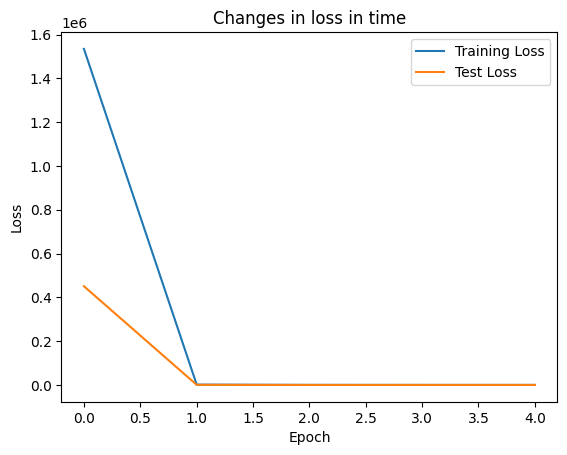

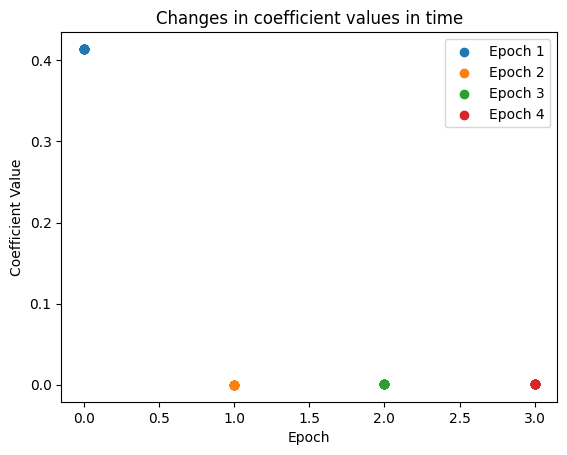

In [ ]:
plot_loss_and_coefficients(df_result_1_2, coef_1_2)

In [ ]:
print(df_result_1_3_1)
print(coef_1_3_1)
print(sindy_model_1_3_1.mask)

          train           test  epoch
0  1.534431e+06  450609.187500      0
1  1.471256e+03     461.749194      1
2  1.635767e+02      30.705959      2
3  3.489544e+01      30.795483      3
4  3.490271e+01      30.827937      4
[tensor([0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140,
        0.4140]), tensor([-0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002,
        -0.0002, -0.0002]), tensor([0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0003]), tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005])]
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


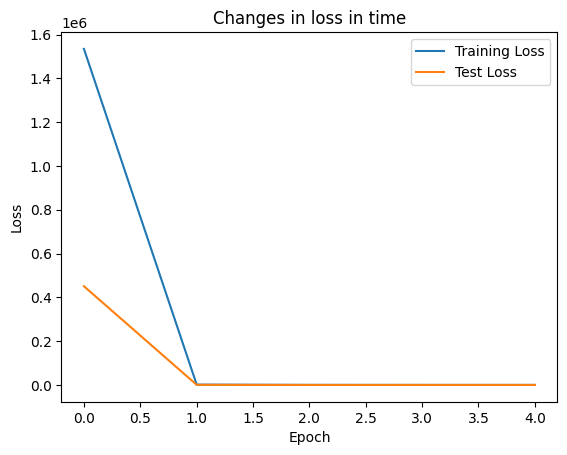

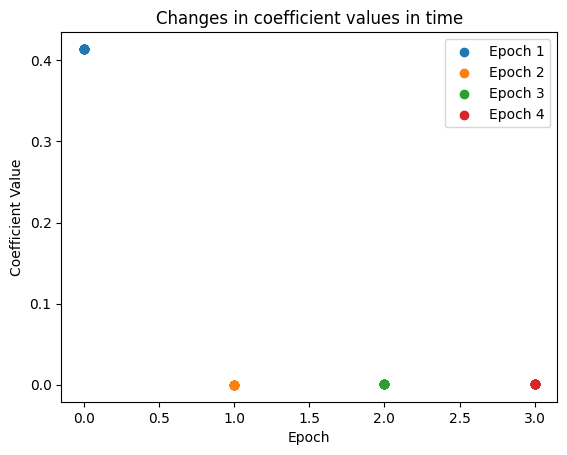

In [ ]:
plot_loss_and_coefficients(df_result_1_3_1, coef_1_3_1)

In [ ]:
print(df_result_1_3_2)
print(coef_1_3_2)
print(sindy_model_1_3_2.mask)

          train           test  epoch
0  1.534431e+06  450609.187500      0
1  3.965046e+03    2406.090554      1
2  1.850164e+03     923.012615      2
3  6.980800e+01      61.473353      3
4  6.980760e+01      61.472918      4
[tensor([0.7070, 0.7070, 0.7070, 0.7070, 0.7070, 0.7070, 0.7070, 0.7070, 0.7070,
        0.7070]), tensor([0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140,
        0.4140]), tensor([-0.0005, -0.0005, -0.0005, -0.0005, -0.0005, -0.0005, -0.0005, -0.0005,
        -0.0005, -0.0005]), tensor([-4.6812e-05, -4.6812e-05, -4.6812e-05, -4.6812e-05, -4.6812e-05,
        -4.6812e-05, -4.6812e-05, -4.6812e-05, -4.6812e-05, -4.6812e-05])]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


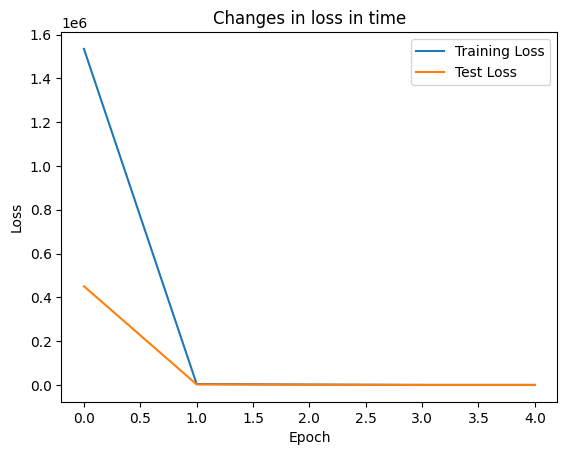

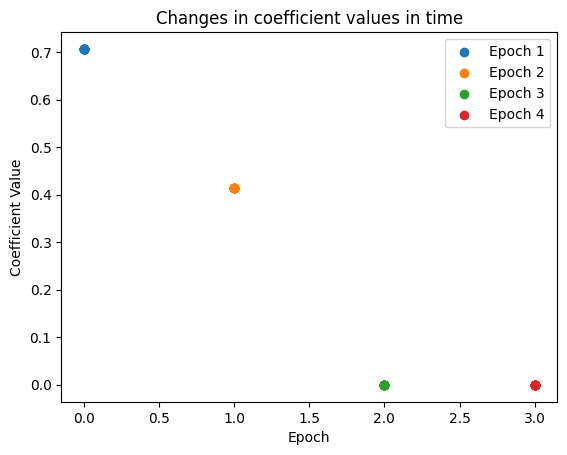

In [ ]:
plot_loss_and_coefficients(df_result_1_3_2, coef_1_3_2)

In [ ]:
print(df_result_1_3_3)
print(coef_1_3_3)
print(sindy_model_1_3_3.mask)

          train           test  epoch
0  1.534431e+06  450609.187500      0
1  1.471256e+03     461.749194      1
2  3.504922e+01      30.745330      2
3  3.490276e+01      30.745391      3
4  3.490276e+01      30.745582      4
[tensor([0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140,
        0.4140]), tensor([-0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002,
        -0.0002, -0.0002]), tensor([0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0003]), tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005])]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


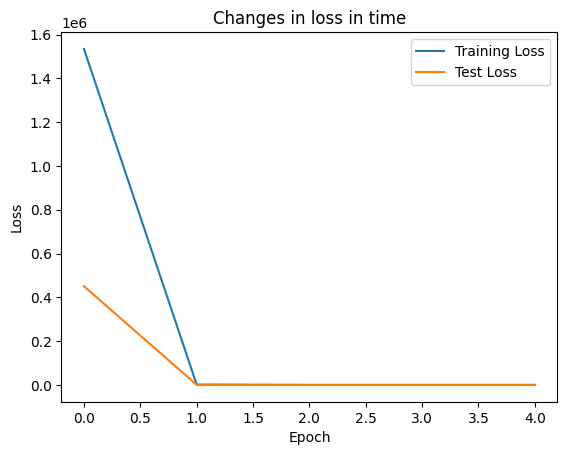

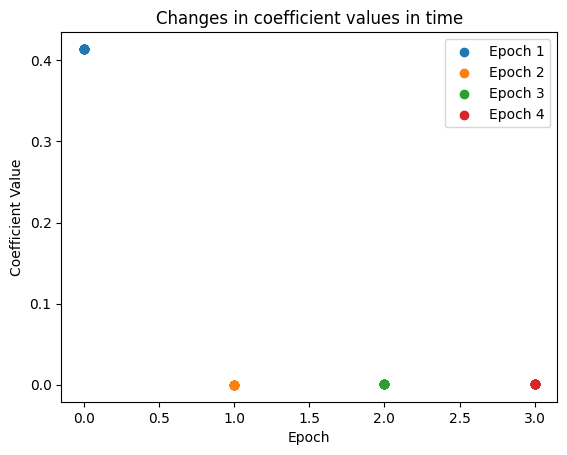

In [ ]:
plot_loss_and_coefficients(df_result_1_3_3, coef_1_3_3)

Comments: 
* We can see that loss decreases for all cases over time, coefficients also do change.
* Unfortunately, we cannot say, that pytorch SINDy model can identify the -sin(z) term. During all simulations we got the same coefficients for all functions. LASSO version is able to do it without any problems.
* In most of the cases the coefficients are close to zero, but unfortunately for all terms, not only to the unused ones.
* Thresholding works - it can change the values of mask, based on the values of coefficients. Unfortunately, due to the problems with coefficients being the same, also masks are the same for all functions, sometimes 1 sometimes 0.


### Resimulation

In [ ]:
some_observation=test_data[0]
first_obs = some_observation[0]
simulated = pendulum_rhs(first_obs[0], first_obs[1], sindy_model.coefficients.data.numpy(), theta)
print(f"Resimulated: {simulated}, from model {first_obs[2]}.")

Resimulated: 0.0006489021268466985, from model 0.49806409558363585.


### Visualization

In [ ]:
def visualize_1_4(coefficients, test_data):
    errors=np.zeros((len(test_data), len(test_data[0])))
    simulated_z = np.zeros((len(coefficients), len(test_data), len(test_data[0])))
    for epoch in range(len(coefficients)):
        for T in range(len(test_data)):
            for N in range(len(test_data[0])):
                simulated = pendulum_rhs(test_data[T][N][0], test_data[T][N][1], coefficients[epoch].numpy(), theta)
                simulated_z[epoch][T][N]=simulated
                errors[T][N]=np.abs(simulated-test_data[T][N][2])
    mean_errors = np.mean(errors, axis=0)
    mean_simulated = np.mean(np.mean(simulated_z, axis= 1), axis=0)

    length=[i+1 for i in range(len(mean_errors))]
    plt.plot(length, mean_errors, label = 'Average errors')
    plt.plot(length, mean_simulated, label = 'Average simulation values')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Simulations over time')
    plt.legend()
    plt.show()

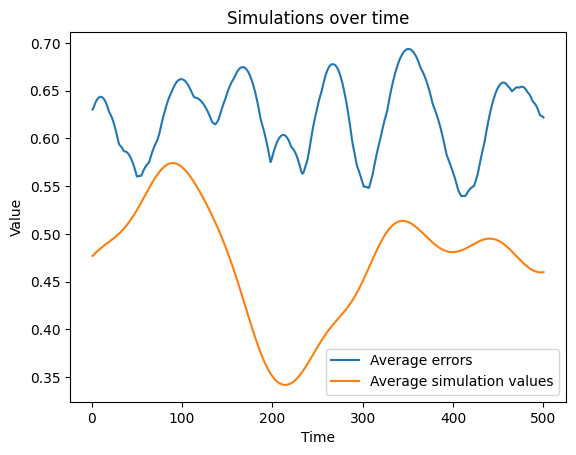

In [ ]:
visualize_1_4(coef_1_2, test_data)

<div style="color: green; font-weight: bold">
Comment - different because of previous error:

* the results of evaluation were not perfect, as can be seen in comments section. This is due to the error in section 1.2. Apart from that, we managed to do evaluate our solution and do some visualizations, which is what was expected.
* however, next time we can try doing better looking visualizations.

</div>

## Task 1.5 - Small Angle Approximation

This time we generate data that show small angles, therefore the initial conditions are between $-\frac{\pi}{36}$ and $\frac{\pi}{36}$.

In [ ]:
# generate small angle data
terms_small = [sin_function]
coeff_val_small = np.array([-1.0])
training_data_small = create_pendulum_data(-np.pi/36, np.pi/36, -2.1, 2.1, coeff_val, 
                         terms, 500, 0.02, 100, embedding=None, rejection=False)

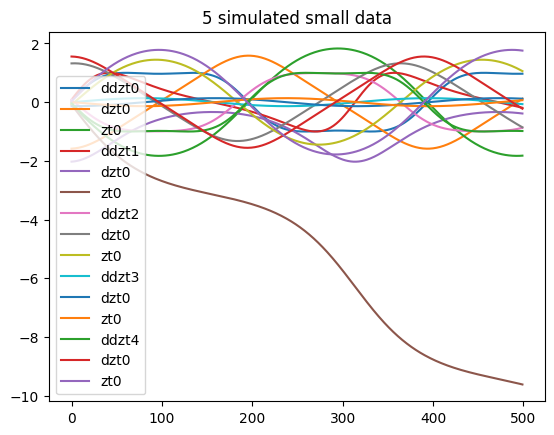

In [ ]:
#plot 5 samples as before, to show the data
plot_function(training_data_small, 5, title="5 simulated small data")

In [ ]:
#train LASSO
z_dot_dot_small, theta_results_small = prepare_data_for_lasso(training_data_small, theta)

clf_small = linear_model.Lasso(alpha=0.1)
clf_small.fit(theta_results_small, z_dot_dot_small)
lasso_coef_small=clf_small.coef_
lasso_coef_small

array([ 0.00000000e+00, -1.95264148e-02, -0.00000000e+00, -7.30769591e-01,
       -1.70219637e-04, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

In [ ]:
#divide into train and test datasets

z_train_small, dz_train_small, ddz_train_small, z_test_small, dz_test_small, ddz_test_small = divide_into_train_and_test(training_data_small)

In [ ]:
#train SINDy

coefficients_small = np.ones(len(theta))
mask_small = np.ones(len(theta))
sindy_model_small = SINDy(coefficients_small, mask_small, theta)

df_result_small, coef_small=train_sindy(sindy_model_small, 
            z_train_small, z_test_small, 
            dz_train_small, dz_test_small,
            ddz_train_small, ddz_test_small, 
            n_epochs=4, batch_size=64, 
            learning_rate=0.001,
            print_logs=True,
            lambda_param = 0.1)

Epoch 0/4: train_loss=6846758.0000, test_loss=4186578.0000, coefficients=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]).
Epoch 1/4: train_loss=7602.2986, test_loss=3722.4985, coefficients=tensor([0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140, 0.4140,
        0.4140]).
Epoch 2/4: train_loss=693.3533, test_loss=30.5979, coefficients=tensor([-0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002, -0.0002,
        -0.0002, -0.0002]).
Epoch 3/4: train_loss=25.1509, test_loss=30.6490, coefficients=tensor([0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0003]).
Epoch 4/4: train_loss=25.1548, test_loss=30.6704, coefficients=tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005]).


In [ ]:
print(f"Coefficients from model SINDy: {sindy_model_small.coefficients.data}.")
print(f"Coefficients from LASSO: {lasso_coef_small}.")

Coefficients from model SINDy: tensor([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0005]).
Coefficients from LASSO: [ 0.00000000e+00 -1.95264148e-02 -0.00000000e+00 -7.30769591e-01
 -1.70219637e-04 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00].


Comments:
* for LASSO we can see there are differences, the coefficients of other functions also sometimes are not equal zero, which means the model this time was not that sure about the correct solution. The reason for that can be that when we generate data with smaller angle, the pendulum swings are smaller and therefore nearer to other functions (when it comes to shape).
* for SINDy model, also this time it gave no meaningful results.

<div style="color: green; font-weight: bold">
Comment - different because of previous error:

* due to the error in section 1.2 our model did not give perfect results, therefore the results here are different than the ones in the sample solution.
* we show here an example of angle, and in the sample solution there are more examples provided - next time we should consider adding more, so that the results could be more diversified.
</div>

## Task 2.1 - Cartesian Embedding

In [ ]:
import numpy as np

def embed_cartesian(z, dz, ddz):
    x = np.array([np.sin(z), -np.cos(z)])
    dx = np.array([np.cos(z) * dz, np.sin(z) * dz])
    ddx = np.array([-np.sin(z) * dz**2 + np.cos(z) * ddz, np.cos(z) * dz**2 + np.sin(z) * ddz])

    return x, dx, ddx

<div style="color: green; font-weight: bold">
Comment - equivalent to the correct solution.
</div>

In [ ]:
# Example usage:
z = np.array([np.pi / 4, np.pi / 2])
dz = np.array([1.0, 0.0])
ddz = np.array([0.0, 0.0])

x, dx, ddx = embed_cartesian(z, dz, ddz)
x, dx, ddx

(array([[ 7.07106781e-01,  1.00000000e+00],
        [-7.07106781e-01, -6.12323400e-17]]),
 array([[0.70710678, 0.        ],
        [0.70710678, 0.        ]]),
 array([[-0.70710678,  0.        ],
        [ 0.70710678,  0.        ]]))

Generating pendulum data with embedding:

In [ ]:
# wrapper for the original data generation that applies embedding
def create_pendulum_data_new(z0_min, z0_max, dz0_min, dz0_max, coefficients, 
                         terms, T, dt, N, embedding=None, rejection=True):
    raw_output = create_pendulum_data(z0_min, z0_max, dz0_min, dz0_max, coefficients, 
                         terms, T, dt, N, embedding, rejection)
    output = raw_output.reshape(-1, 3)

    # apply embedding
    if embedding is not None:
        z = output[:, 0]
        dz = output[:, 1]
        ddz = output[:, 2]
        output = np.array(embedding(z, dz, ddz))
        output = np.transpose(output, (2, 0, 1))
    
    return output

simulation_params = {
    "z0_min": -np.pi,
    "z0_max": np.pi,
    "dz0_min": -2.1,
    "dz0_max": 2.1,
    "coefficients": np.array([-1.0]),
    "terms": [sin_function],
    "T": 50,
    "dt": 0.02,
    "N": 100,
    "embedding": embed_cartesian, # <- new
    "rejection": True,
}
training_data_cartesian = create_pendulum_data_new(**simulation_params)

print(f"Shape of training data: {training_data_cartesian.shape}")
print(f"Example: {training_data_cartesian[0]}")

Shape of training data: (5000, 3, 2)
Example: [[-0.28028422 -0.95991706]
 [-1.86854897  0.54559379]
 [ 1.33108793  3.55870838]]


<div style="color: green; font-weight: bold">
Comment - example not present in the correct solution. Correct.
</div>

## Task 2.2 - Hyperparameter Optimization

In [ ]:
class SimpleAutoencoder(nn.Module):
    def __init__(self, hidden_dims_list, input_dim=2, latent_dim=1):
        super(SimpleAutoencoder, self).__init__()
        # input_dim size of x_t is 2 (2D cartesian coordinates)
        # latent_dim has to recontruct the angle (1D) of pendulum
        
        # create encoder layers (linear + sigmoid)
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dims_list[0]))
        layers.append(nn.Sigmoid())
        for i in range(len(hidden_dims_list)-1):
            layers.append(nn.Linear(hidden_dims_list[i], hidden_dims_list[i+1]))
            layers.append(nn.Sigmoid())
        layers.append(nn.Linear(hidden_dims_list[-1], latent_dim))
        self.encoder = nn.Sequential(*layers)

        # create decoder layers (inverse order of sizes the encoder layers)
        layers = []
        layers.append(nn.Linear(latent_dim, hidden_dims_list[-1]))
        layers.append(nn.Sigmoid())
        for i in range(len(hidden_dims_list)-1):
            layers.append(nn.Linear(hidden_dims_list[-i-1], hidden_dims_list[-i-2]))
            layers.append(nn.Sigmoid())
        layers.append(nn.Linear(hidden_dims_list[0], input_dim))
        self.decoder = nn.Sequential(*layers)

    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        x_reconstructed = self.decode(z)
        return x_reconstructed

<div style="color: green; font-weight: bold">
Comment - different from the correct solution:

- we did not disable bias when using the default Linear layers. We believe it does not really matter as soon we changed the default Linear layers custom Linear layer that correctly disable bias (see below).
- rest is the same, apart from the fact, the our forward pass of the model returns only the reconstructed input and the correct solution also returns the latent space representation. It is unimportant as it is not used in the training process.

Additionally, we included the Xavier initialization of weights later instead of right away here.
</div>

In [ ]:
# a simple training of an autoencoder network

def train_simple_autoencoder(model, 
                            X_train, X_test, 
                            n_epochs, batch_size, 
                            learning_rate=0.001,
                            print_logs=True):
    """
    Args:
        model - autoencoder
        X - input that will be encoded and decoded
        n_epochs - number of epochs
        batch_size - batch size
        learning_rate - learning rate
    """

    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []
    
    X_train = torch.from_numpy(X_train).float()
    X_test = torch.from_numpy(X_test).float()

    # loss before training
    with torch.no_grad():
        loss = loss_function(model(X_train), X_train)
        train_losses.append(loss.item())
        loss = loss_function(model(X_test), X_test)
        test_losses.append(loss.item())
    if print_logs:
        print(f"Epoch 0/{n_epochs}: train_loss={train_losses[-1]:.4f}, test_loss={test_losses[-1]:.4f}")

    # training
    for epoch in range(n_epochs):
        train_loss = 0
        test_loss = 0
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            optimizer.zero_grad()
            loss = loss_function(model(X_batch), X_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(X_batch)
        train_loss /= len(X_train)
        train_losses.append(train_loss)

        with torch.no_grad():
            for i in range(0, len(X_test), batch_size):
                X_batch = X_test[i:i+batch_size]
                loss = loss_function(model(X_batch), X_batch)
                test_loss += loss.item() * len(X_batch)
            test_loss /= len(X_test)
            test_losses.append(test_loss)
            
        if (epoch+1) % (n_epochs//10+1) == 0 or epoch == n_epochs-1:
            if print_logs:
                print(f"Epoch {epoch+1}/{n_epochs}: train_loss={train_loss:.4f}, test_loss={test_loss:.4f}")
    df = pd.DataFrame({'train': train_losses, 'test': test_losses, 'epoch': list(range(n_epochs+1))})
    return df

<div style="color: green; font-weight: bold">
Comment - equivalent to the correct solution.
</div>

In [ ]:
sample_model = SimpleAutoencoder(hidden_dims_list=[16,16]) # default input is 2D x_t and latent space is 1D z_t
print(sample_model)

SimpleAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=16, out_features=2, bias=True)
  )
)


In [ ]:
# split training_data_cartesian into train and test with sklearn
from sklearn.model_selection import train_test_split

data_cartesian_train, data_cartesian_test = train_test_split(training_data_cartesian,
                                                            random_state=104,  
                                                            test_size=0.2,  
                                                            shuffle=True)

X_train = data_cartesian_train[:,0,:]
X_test = data_cartesian_test[:,0,:]

X_train.shape, X_test.shape

((4000, 2), (1000, 2))

<div style="color: green; font-weight: bold">
Comment - equivalent but different: we used train set of 4000 samples, the correct solution used 5000 samples.
</div>

In [ ]:
# train a sample model
simple_autoencoder = SimpleAutoencoder(hidden_dims_list=[16,16])
df = train_simple_autoencoder(simple_autoencoder, X_train, X_test, n_epochs=100, batch_size=128)
df

Epoch 0/100: train_loss=0.8539, test_loss=0.8784
Epoch 11/100: train_loss=0.4386, test_loss=0.4275


Epoch 22/100: train_loss=0.2122, test_loss=0.2026
Epoch 33/100: train_loss=0.1767, test_loss=0.1742
Epoch 44/100: train_loss=0.1287, test_loss=0.1223
Epoch 55/100: train_loss=0.0497, test_loss=0.0468
Epoch 66/100: train_loss=0.0247, test_loss=0.0233
Epoch 77/100: train_loss=0.0117, test_loss=0.0116
Epoch 88/100: train_loss=0.0075, test_loss=0.0077
Epoch 99/100: train_loss=0.0051, test_loss=0.0053
Epoch 100/100: train_loss=0.0049, test_loss=0.0051


,train,test,epoch
0,0.853894,0.878385,0
1,0.686428,0.553886,1
2,0.492949,0.449131,2
3,0.446007,0.432370,3
4,0.441494,0.431151,4
...,...,...,...
96,0.005641,0.005855,96
97,0.005445,0.005660,97
98,0.005256,0.005471,98
99,0.005074,0.005288,99


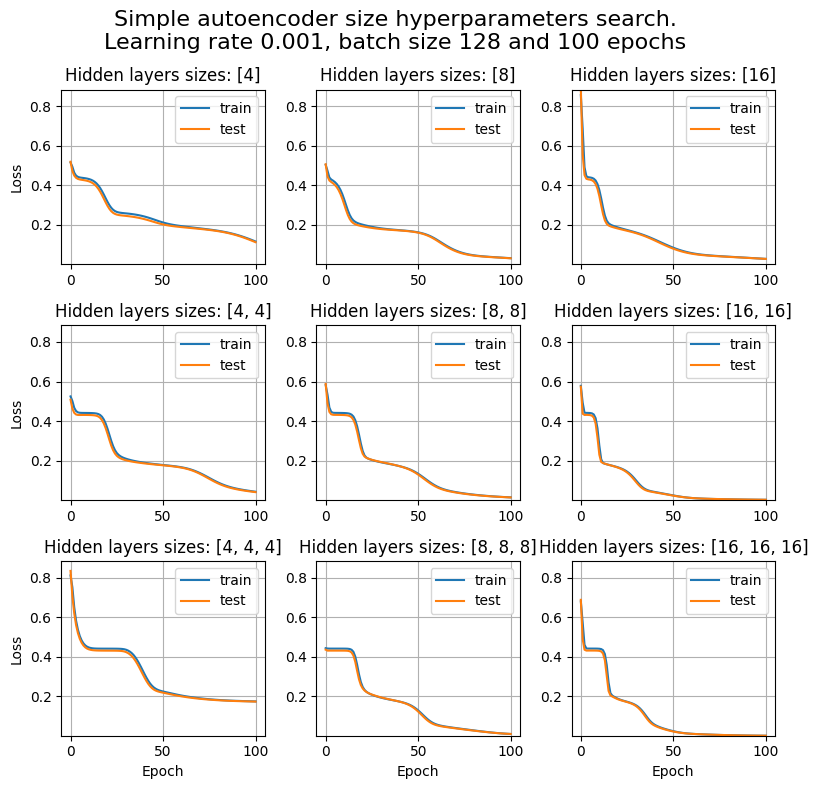

In [ ]:
# training parameters
epochs = 100
batch_size = 128

autoencoder_hyperparams_to_check = [
    {'hidden_dims_list': [4]},
    {'hidden_dims_list': [8]},
    {'hidden_dims_list': [16]},
    {'hidden_dims_list': [4,4]},
    {'hidden_dims_list': [8,8]},
    {'hidden_dims_list': [16,16]},
    {'hidden_dims_list': [4,4,4]},
    {'hidden_dims_list': [8,8,8]},
    {'hidden_dims_list': [16,16,16]},
]

# train all models
x_min = np.inf
x_max = -np.inf
results = []
for hyperparams in autoencoder_hyperparams_to_check:
    model = SimpleAutoencoder(**hyperparams)
    df = train_simple_autoencoder(model, X_train, X_test, n_epochs=epochs, batch_size=batch_size, print_logs=False)
    results.append({'df': df, 'hyperparams': hyperparams})
    x_min = min(x_min, df['train'].min(), df['test'].min())
    x_max = max(x_max, df['train'].max(), df['test'].max())

# plot results in a 3x3 grid
fig, axs = plt.subplots(3, 3, figsize=(8,8))
for i, result in enumerate(results):
    ax = axs[i//3, i%3]
    result['df'].plot(x='epoch', y=['train', 'test'], grid=True, ax=ax)
    if i//3 == 2:
        ax.set_xlabel('Epoch')
    else:
        ax.set_xlabel('')
    if i%3 == 0:
        ax.set_ylabel('Loss')
    else:
        ax.set_ylabel('')
    ax.set_ylim(x_min, x_max)
    ax.set_title(f"Hidden layers sizes: {result['hyperparams']['hidden_dims_list']}")
fig.suptitle(f"Simple autoencoder size hyperparameters search.\nLearning rate 0.001, batch size {batch_size} and {epochs} epochs", fontsize=16)
fig.tight_layout()
plt.show()

Based on the hyperparameter optimization, the best size of the autoencoder is the largest with 3 layers, each of size 16. However, just 2 layers of size 8 are nearly the same but substantially smaller thus we will use this architecture in the next tasks.

<div style="color: green; font-weight: bold">
Comment - equivalent to the correct solution:

- we evaluated different autoencoder sizes.
- the correct solution does not include any comment about the results of the hyperparameter optimization.

The correct solution is better because it repeated each training a few times.
</div>

## Task 2.3 - Propagation of Time Derivatives

Should match the task description, but also Section 'S1.3  Computing derivatives' from the paper linked in the task description later (https://arxiv.org/pdf/1904.02107.pdf).

In [ ]:
def sigmoid(x):
    return torch.sigmoid(x)

def sigmoid_prim(x):
    return sigmoid(x) * (1 - sigmoid(x))

def sigmoid_bis(x):
    return sigmoid_prim(x) * (1 - 2 * sigmoid(x))

class SigmoidDerivatives(nn.Module):
    def forward(self, x, dx, ddx):
        z = sigmoid(x)
        dz = sigmoid_prim(x) * dx
        ddz = (sigmoid_bis(x) * dx) * dx + sigmoid_prim(x) * ddx
        return z, dz, ddz

class LinearDerivatives(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearDerivatives, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, x, dx, ddx):
        z = self.linear(x)
        dz = F.linear(dx, self.linear.weight)       # without bias term
        ddz = F.linear(ddx, self.linear.weight)     # without bias term
        return z, dz, ddz

<div style="color: green; font-weight: bold">
Comment - equivalent but different: ours solution is less general but shorter. Bias in linear layers is used correctly.
</div>

### Verifying the correctness of the time derivatives propagation

<div style="color: green; font-weight: bold">
Comment - this section is not present in the correct solution at subtask 2.3, but correct.
</div>

In [ ]:
def get_fake_data_constant_speed():
    # fake data: X_train is a list of N points in time, each with 2D cartesian coordinates, their first, and their second derivatives, so N x 3 x 2

    # here, we start at point (0,0) and move in the x direction with constnant speed 1, s=x_0 + v_0 * t
    X_train = np.array([[[0, 0], [1, 0], [0, 0]], 
                        [[1, 0], [1, 0], [0, 0]], 
                        [[2, 0], [1, 0], [0, 0]]])
    X_train = torch.from_numpy(X_train).float()

    # Sample time interval
    delta_T = 1

    return X_train, delta_T


def get_fake_data_constant_acceleration():
    # fake data: X_train is a list of N points in time, each with 2D cartesian coordinates, their first, and their second derivatives, so N x 3 x 2

    # here, we start at point (0,0) and move in the x direction with starting speed 1 and acceleration 1, s=x_0 + v_0 * t + 1/2 * a * t^2
    X_train = np.array([[[0, 0], [1, 0], [1, 0]], 
                        [[2, 0], [2, 0], [1, 0]], 
                        [[5, 0], [3, 0], [1, 0]]])
    X_train = torch.from_numpy(X_train).float()

    # Sample time interval
    delta_T = 1

    return X_train, delta_T

In [ ]:
def compute_empirical_derivatives(z_t1, z_t2, z_t3, delta_T):
    """Computes the first and second derivatives based on the given 3 points in time. At the middle point."""
    z_dot_empirical = (z_t3 - z_t1) / (2 * delta_T)                     # this will not be exact when speed is changing
    zz_dot_empirical = ((z_t3 - z_t2) - (z_t2 - z_t1)) / (delta_T**2)   # differs from the formula in the task description, but I believe it is correct
    
    return z_dot_empirical, zz_dot_empirical

In [ ]:
def check_derivatives_correctness(model, data, delta_T, function_computing_empirical_derivatives=compute_empirical_derivatives):
    # take first 3 points from the training set
    X_t1 = data[0]
    X_t2 = data[1]
    X_t3 = data[2]
    
    # compute model outputs for the first 3 points
    z1, dz1, ddz1 = model(X_t1[0], X_t1[1], X_t1[2])
    z2, dz2, ddz2 = model(X_t2[0], X_t2[1], X_t2[2])
    z3, dz3, ddz3 = model(X_t3[0], X_t3[1], X_t3[2])

    # Compute empirical derivatives based on layer outputs for these 3 time points (for the middle one)
    z_dot_empirical1, zz_dot_empirical1 = function_computing_empirical_derivatives(z1, z2, z3, delta_T)

    # compare with the model outputs for the last layer
    print("Derivatives at the middle point in time:")
    print()
    print("Empirical first order derivative:", z_dot_empirical1[0].item())
    print("Model's output:", dz2[0].item())
    print()
    print("Empirical decondorder derivative:", zz_dot_empirical1[0].item())
    print("Model's output:", ddz2[0].item())

#### Example 1 - constant speed, no acceleration

In [ ]:
data, delta_T = get_fake_data_constant_speed()
model = SigmoidDerivatives()
check_derivatives_correctness(model, data, delta_T)

Derivatives at the middle point in time:

Empirical first order derivative: 0.19039851427078247
Model's output: 0.1966119259595871

Empirical decondorder derivative: -0.08132016658782959
Model's output: -0.09085775166749954


In [ ]:
data, delta_T = get_fake_data_constant_speed()
model = LinearDerivatives(input_dim=2, output_dim=1)
check_derivatives_correctness(model, data, delta_T)

Derivatives at the middle point in time:

Empirical first order derivative: -0.3006187081336975
Model's output: -0.3006187081336975

Empirical decondorder derivative: 0.0
Model's output: 0.0


### Example 2 - constant acceleration

In [ ]:
data, delta_T = get_fake_data_constant_acceleration()
model = SigmoidDerivatives()
check_derivatives_correctness(model, data, delta_T)

Derivatives at the middle point in time:

Empirical first order derivative: 0.24665358662605286
Model's output: 0.20998725295066833

Empirical decondorder derivative: -0.26828688383102417
Model's output: -0.21485646069049835


In [ ]:
data, delta_T = get_fake_data_constant_acceleration()
model = LinearDerivatives(input_dim=2, output_dim=1)
check_derivatives_correctness(model, data, delta_T)

Derivatives at the middle point in time:

Empirical first order derivative: -0.8617029190063477
Model's output: -0.6893622875213623

Empirical decondorder derivative: -0.3446812629699707
Model's output: -0.34468114376068115


Obtained results are nearly the same for both sample data (with constant speed or acceleration).

<div style="color: green; font-weight: bold">
Comment - the section above is not present in the correct solution at subtask 2.3, but correct.
</div>

## Task 2.4 - Implementation

In [ ]:
# create a custom sequential class that allows to pass additional arguments to the forward method
class CustomSequential(nn.Sequential):
    def forward(self, *input, **kwargs):
        for module in self._modules.values():
            input = module(*input, **kwargs)
        return input

class SimpleAutoencoderWithDerivatives(nn.Module):
    def __init__(self, hidden_dims_list, input_dim=2, latent_dim=1):
        super(SimpleAutoencoderWithDerivatives, self).__init__()
        
        # create encoder layers (LinearDerivatives + SigmoidDerivatives)
        layers = []
        layers.append(LinearDerivatives(input_dim, hidden_dims_list[0]))
        layers.append(SigmoidDerivatives())
        for i in range(len(hidden_dims_list)-1):
            layers.append(LinearDerivatives(hidden_dims_list[i], hidden_dims_list[i+1]))
            layers.append(SigmoidDerivatives())
        layers.append(LinearDerivatives(hidden_dims_list[-1], latent_dim))
        self.encoder = CustomSequential(*layers)

        # create decoder layers (inverse order of sizes the encoder layers)
        layers = []
        layers.append(LinearDerivatives(latent_dim, hidden_dims_list[-1]))
        layers.append(SigmoidDerivatives())
        for i in range(len(hidden_dims_list)-1):
            layers.append(LinearDerivatives(hidden_dims_list[-i-1], hidden_dims_list[-i-2]))
            layers.append(SigmoidDerivatives())
        layers.append(LinearDerivatives(hidden_dims_list[0], input_dim))
        self.decoder = CustomSequential(*layers)

    def encode(self, x, dx, ddx):
        z, dz, ddz = self.encoder(x, dx, ddx)
        return z, dz, ddz
    
    def decode(self, z, dz, ddz):
        x_reconstructed, dx_reconstructed, ddx_reconstructed = self.decoder(z, dz, ddz)
        return x_reconstructed, dx_reconstructed, ddx_reconstructed

    def forward(self, x, dx, ddx):
        z, dz, ddz = self.encode(x, dx, ddx)
        x_reconstructed, dx_reconstructed, ddx_reconstructed = self.decode(z, dz, ddz)
        return x_reconstructed, dx_reconstructed, ddx_reconstructed
    
def weights_init_xavier_uniform_no_bias(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)     # weights are initialized with xavier uniform
        m.bias.data.fill_(0)                       # bias is disabled (is set to 0, same as in the paper in Section S1.4)

<div style="color: green; font-weight: bold">
Comment - equivalent to the correct solution.

We implement the autoencoder separately from the sindy model (which is added to a new model later). The correct solution implements both in one class.

Weights are initialized with Xavier initialization similarly to the correct solution except that we explicitly set the bias to zero whereas the correct solution disables bias when creating the Linear layers.
</div>

Initialization with xavier uniform and disabled bias.

In [ ]:
autoencoder_with_derivatives = SimpleAutoencoderWithDerivatives(hidden_dims_list=[8,8])
autoencoder_with_derivatives = autoencoder_with_derivatives.apply(weights_init_xavier_uniform_no_bias)

Sample autoencoder's input and output:

In [ ]:
data, delta_T = get_fake_data_constant_speed()
print('data shape:', data.shape)
print('autoencoder\'s output:')
autoencoder_with_derivatives.forward(data[0][0], data[0][1], data[0][2])

data shape: torch.Size([3, 3, 2])
autoencoder's output:


(tensor([ 1.0553, -0.1939], grad_fn=<ViewBackward0>),
 tensor([0.0021, 0.0009], grad_fn=<SqueezeBackward4>),
 tensor([-3.8447e-05, -1.8355e-05], grad_fn=<SqueezeBackward4>))

### Verifying the correctness of the time derivatives propagation

<div style="color: green; font-weight: bold">
Comment - this section is different from the correct solution but equivalent and correct.

We could improve our solution by including plots that the correct solution included.
</div>

In [ ]:
model = SimpleAutoencoderWithDerivatives(hidden_dims_list=[8,8])
model = model.apply(weights_init_xavier_uniform_no_bias)

#### Example 1 - constant speed, no acceleration

In [ ]:
data, delta_T = get_fake_data_constant_speed()
check_derivatives_correctness(model, data, delta_T)

Derivatives at the middle point in time:

Empirical first order derivative: -0.0021148622035980225
Model's output: -0.0021559891756623983

Empirical decondorder derivative: 0.00030994415283203125
Model's output: 0.00032222550362348557


### Example 2 - constant acceleration

In [ ]:
data, delta_T = get_fake_data_constant_acceleration()
check_derivatives_correctness(model, data, delta_T)

Derivatives at the middle point in time:

Empirical first order derivative: -0.0036474913358688354
Model's output: -0.003471908625215292

Empirical decondorder derivative: 0.001164466142654419
Model's output: 0.00022054703731555492


Obtained results are nearly the same for both sample data (with constant speed or acceleration).

<div style="color: green; font-weight: bold">
Comment - section above is different from the correct solution but equivalent and correct.
</div>

#### Testing if the SINDyAutoencoder is implemented correctly

The interpretation of the task description is as follows:
- $\hat{x}$ - x after encoding + decoding
- $\ddot{z}$ - x second derivative after encoding
- $\hat{\ddot{z}}$ - x and x first derivative after encoding + SINDy
- $\hat{\ddot{x}}$ - (x and x first derivative after encoding + SINDy) + decoding

In [ ]:
class SINDyAutoencoder(nn.Module):
    def __init__(self, SINDy_model_params, autoencoder_hidden_dims_list, input_dim=2, latent_dim=1):
        super(SINDyAutoencoder, self).__init__()
        
        sindy = SINDy(**SINDy_model_params)
        self.SINDy_model = sindy

        autoencoder = SimpleAutoencoderWithDerivatives(autoencoder_hidden_dims_list, input_dim, latent_dim)
        autoencoder = autoencoder.apply(weights_init_xavier_uniform_no_bias)
        self.encoder = autoencoder.encoder
        self.decoder = autoencoder.decoder

    def forward(self, x, dx, ddx):
        # encode
        z, dz, ddz = self.encoder(x, dx, ddx)

        # SINDy
        ddz_hat_sindy = self.SINDy_model(z, dz)
        ddz_hat_sindy = ddz_hat_sindy.unsqueeze(-1)

        # decode
        x_hat, dx_hat, ddx_hat_sindy = self.decoder(z, dz, ddz_hat_sindy)

        return x_hat, ddz, ddz_hat_sindy, ddx_hat_sindy

<div style="color: green; font-weight: bold">
Comment - different from the correct solution:

- GPU (CUDA) support is not implemented in ours solution.
- output of the forward method is different. This does not matter as long as the training loop uses the model correctly.
  - output's order in our solution is: 
    - decoded (2D) autoencoder's output, 
    - encoded (1D) autoencoder's input second derivative, 
    - SINDy's output, 
    - decoded (2D) autoencoder's output second derivative (decoded with using SINDy's output)
  - output's order in the correct solution is:
    - decoded (2D) autoencoder's output, 
    - decoded (2D) autoencoder's output second derivative (decoded with using SINDy's output)
    - encoded (1D) autoencoder's input second derivative, 
    - SINDy's output, 

Other than that, we believe that separating the sindy from the autoencoder implementation (as in our solution) is clearer than the correct solution where both are implemented in one class.


</div>

In [ ]:
theta # there are 10 functions in theta, as defined earlier

[<function __main__.f1(z, dz)>,
 <function __main__.f2(z, dz)>,
 <function __main__.f3(z, dz)>,
 <function __main__.f4(z, dz)>,
 <function __main__.f5(z, dz)>,
 <function __main__.f6(z, dz)>,
 <function __main__.f7(z, dz)>,
 <function __main__.f8(z, dz)>,
 <function __main__.f9(z, dz)>,
 <function __main__.f10(z, dz)>]

<div style="color: green; font-weight: bold">
Comment - equivalent to the correct solution but the correct solution is much better in terms of readability and clarity.
</div>

In [ ]:
SINDy_model_params = {
    "coefficients": np.ones(len(theta)),
    "mask": np.ones(len(theta)),
    "terms": theta,
}

sindy_autoencoder = SINDyAutoencoder(SINDy_model_params, autoencoder_hidden_dims_list=[8,8])

print(f"SINDy trainable params: {list(sindy_autoencoder.SINDy_model.parameters())}")
print("\nWhole SINDy with autoencoder (properly initialized):")
sindy_autoencoder

SINDy trainable params: [Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)]

Whole SINDy with autoencoder (properly initialized):


SINDyAutoencoder(
  (SINDy_model): SINDy()
  (encoder): CustomSequential(
    (0): LinearDerivatives(
      (linear): Linear(in_features=2, out_features=8, bias=True)
    )
    (1): SigmoidDerivatives()
    (2): LinearDerivatives(
      (linear): Linear(in_features=8, out_features=8, bias=True)
    )
    (3): SigmoidDerivatives()
    (4): LinearDerivatives(
      (linear): Linear(in_features=8, out_features=1, bias=True)
    )
  )
  (decoder): CustomSequential(
    (0): LinearDerivatives(
      (linear): Linear(in_features=1, out_features=8, bias=True)
    )
    (1): SigmoidDerivatives()
    (2): LinearDerivatives(
      (linear): Linear(in_features=8, out_features=8, bias=True)
    )
    (3): SigmoidDerivatives()
    (4): LinearDerivatives(
      (linear): Linear(in_features=8, out_features=2, bias=True)
    )
  )
)

In [ ]:
len(list(sindy_autoencoder.parameters())) # 1 for sindy, 2 per each layer in autoencoder (12 total)

13

<div style="color: green; font-weight: bold">
Comment - check not present in the correct solution.
</div>

Implementation of the basic train_sindy_autoencoder training loop.

In [ ]:
def SINDyAutoencoder_loss(x_dx_ddx, sindy_autoencoder, lambda_ddz, lambda_ddx, lambda_L1):
    x, dx, ddx = x_dx_ddx[:,0,:], x_dx_ddx[:,1,:], x_dx_ddx[:,2,:]

    x_hat, ddz, ddz_hat_sindy, ddx_hat = sindy_autoencoder(x, dx, ddx)
    
    autoencoder_mse = torch.mean((x - x_hat)**2)
    sindy_ddz_mse = torch.mean((ddz - ddz_hat_sindy)**2)
    sindy_ddx_mse = torch.mean((ddx - ddx_hat)**2)
    sindy_L1 = torch.sum(torch.abs(sindy_autoencoder.SINDy_model.coefficients))
    
    loss = autoencoder_mse + lambda_ddz * sindy_ddz_mse + lambda_ddx * sindy_ddx_mse + lambda_L1 * sindy_L1
    return loss

def train_sindy_autoencoder(model, 
                            X_train, X_test, 
                            batch_size, learning_rate,
                            training_epochs, # refinement_start_epoch,   # <- added in Task 2.5
                            use_sequential_thresholding, sequential_thresholding_epochs, threshold_a,
                            use_ptat_thresholding, ptat_patience_epochs, threshold_b,
                            lambda_ddz, lambda_ddx, lambda_L1):
    """
    Args:
        model - SINDyAutoencoder
        x, dx, ddx - training data
        batch_size - batch size
        learning_rate - learning rate
        training_epochs - number of epochs for training
        # refinement_start_epoch - at this epochs, L0 regularization is turned off
        use_sequential_thresholding - whether to use sequential thresholding
        sequential_thresholding_epochs - number of epochs for sequential thresholding
        threshold_a - threshold for sequential thresholding
        use_ptat_thresholding - whether to use patient thresholding
        ptat_patience_epochs - number of epochs for patient thresholding
        threshold_b - threshold for patient thresholding
        lambda_ddz - regularization parameter for ddz
        lambda_ddx - regularization parameter for ddx
        lambda_L1 - regularization parameter for L1 norm of SINDy coefficients
    """
    
    loss_function = partial(SINDyAutoencoder_loss, lambda_ddz=lambda_ddz, 
                            lambda_ddx=lambda_ddx, lambda_L1=lambda_L1)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []
    
    X_train = torch.from_numpy(X_train).float()
    X_test = torch.from_numpy(X_test).float()

    # for PTAT thresholding
    sindy_coef_shape = model.SINDy_model.coefficients.shape
    coefficients_prev = torch.zeros(sindy_coef_shape)
    Ea = torch.zeros(sindy_coef_shape)
    Eb = torch.zeros(sindy_coef_shape)

    # loss before training
    with torch.no_grad():
        loss = loss_function(X_train, model)
        train_losses.append(loss.item())
        loss = loss_function(X_test, model)
        test_losses.append(loss.item()) 
    print(f"Epoch 0/{training_epochs}: train_loss={train_losses[-1]:.4f}, test_loss={test_losses[-1]:.4f}")

    # training
    for epoch in range(training_epochs):
        train_loss = 0
        test_loss = 0
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            optimizer.zero_grad()
            loss = loss_function(X_batch, model)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(X_batch)
        train_loss /= len(X_train)
        train_losses.append(train_loss)

        # eval
        with torch.no_grad():
            for i in range(0, len(X_test), batch_size):
                X_batch = X_test[i:i+batch_size]
                loss = loss_function(X_batch, model)
                test_loss += loss.item() * len(X_batch)
            test_loss /= len(X_test)
            test_losses.append(test_loss)

        # thresholding - sequential
        if use_sequential_thresholding and (epoch+1) % sequential_thresholding_epochs == 0:
            mask_BigXi = torch.abs(model.SINDy_model.coefficients.data) < threshold_a
            model.SINDy_model.coefficients.data[mask_BigXi] = 0
            model.SINDy_model.mask[mask_BigXi] = 0

        # thresholding - PTAT
        if use_ptat_thresholding:
            mask_a = torch.abs(model.SINDy_model.coefficients.data) > threshold_a
            mask_b = torch.abs(model.SINDy_model.coefficients.data - coefficients_prev) > threshold_b

            Ea[mask_a] = epoch
            Eb[mask_b] = epoch

            mask_trend_aware = ((epoch - Ea) < ptat_patience_epochs) | ((epoch - Eb) < ptat_patience_epochs)
            model.SINDy_model.mask = model.SINDy_model.mask * mask_trend_aware

            coefficients_prev = model.SINDy_model.coefficients.data.clone()
            
        if (epoch+1) % (training_epochs//10+1) == 0 or epoch == training_epochs-1:
            print(f"Epoch {epoch+1}/{training_epochs}: train_loss={train_loss:.4f}, test_loss={test_loss:.4f}")
    df = pd.DataFrame({'train': train_losses, 'test': test_losses, 'epoch': list(range(training_epochs+1))})
    return df

<div style="color: green; font-weight: bold">
Comment - Loss is computed correctly. Training loop is reviewed in subtask 2.5.
</div>

Sample training with all training data:

In [ ]:
X_train = data_cartesian_train
X_test = data_cartesian_test

X_train.shape

(4000, 3, 2)

In [ ]:
train_sindy_autoencoder(sindy_autoencoder,
                        X_train, X_test,
                        batch_size=128, learning_rate=0.001,
                        training_epochs=10, # refinement_start_epoch,   # <- added in Task 2.5
                        use_sequential_thresholding=True, sequential_thresholding_epochs=3, threshold_a=0.1,
                        use_ptat_thresholding=True, ptat_patience_epochs=3, threshold_b=0.1,
                        lambda_ddz=0.1, lambda_ddx=0.1, lambda_L1=0.1)

Epoch 0/10: train_loss=1.8667, test_loss=1.8718
Epoch 2/10: train_loss=1.6944, test_loss=1.6681


Epoch 4/10: train_loss=1.6277, test_loss=1.6023
Epoch 6/10: train_loss=1.5483, test_loss=1.5137
Epoch 8/10: train_loss=1.4596, test_loss=1.4254
Epoch 10/10: train_loss=1.3763, test_loss=1.3431


,train,test,epoch
0,1.866660,1.871786,0
1,1.785484,1.728439,1
2,1.694412,1.668089,2
3,1.655479,1.636152,3
4,1.627750,1.602269,4
5,1.591689,1.559620,5
6,1.548347,1.513733,6
7,1.503380,1.468657,7
8,1.459570,1.425404,8
9,1.417338,1.383692,9


Training function seems to work (including every thresholding parameters)

<div style="color: green; font-weight: bold">
Comment - sample training is not present in the correct solution.
</div>

## Task 2.5 - Refinement

In [ ]:
def train_sindy_autoencoder(model, 
                            X_train, X_test, 
                            batch_size, learning_rate,
                            training_epochs, refinement_start_epoch,   # <- added new parameter 
                            use_sequential_thresholding, sequential_thresholding_epochs, threshold_a,
                            use_ptat_thresholding, ptat_patience_epochs, threshold_b,
                            lambda_ddz, lambda_ddx, lambda_L1):
    """
    Args:
        model - SINDyAutoencoder
        x, dx, ddx - training data
        batch_size - batch size
        learning_rate - learning rate
        training_epochs - number of epochs for training
        refinement_start_epoch - at this epochs, L0 regularization is turned off <- NEW
        use_sequential_thresholding - whether to use sequential thresholding
        sequential_thresholding_epochs - number of epochs for sequential thresholding
        threshold_a - threshold for sequential thresholding
        use_ptat_thresholding - whether to use patient thresholding
        ptat_patience_epochs - number of epochs for patient thresholding
        threshold_b - threshold for patient thresholding
        lambda_ddz - regularization parameter for ddz
        lambda_ddx - regularization parameter for ddx
        lambda_L1 - regularization parameter for L1 norm of SINDy coefficients
    """
    
    loss_function = partial(SINDyAutoencoder_loss, lambda_ddz=lambda_ddz, 
                            lambda_ddx=lambda_ddx, lambda_L1=lambda_L1)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []
    
    X_train = torch.from_numpy(X_train).float()
    X_test = torch.from_numpy(X_test).float()

    # for PTAT thresholding
    sindy_coef_shape = model.SINDy_model.coefficients.shape
    coefficients_prev = torch.zeros(sindy_coef_shape)
    Ea = torch.zeros(sindy_coef_shape)
    Eb = torch.zeros(sindy_coef_shape)

    # loss before training
    with torch.no_grad():
        loss = loss_function(X_train, model)
        train_losses.append(loss.item())
        loss = loss_function(X_test, model)
        test_losses.append(loss.item()) 
    print(f"Epoch 0/{training_epochs}: train_loss={train_losses[-1]:.4f}, test_loss={test_losses[-1]:.4f}")

    # training
    for epoch in range(training_epochs):
            
        train_loss = 0
        test_loss = 0
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            optimizer.zero_grad()
            loss = loss_function(X_batch, model)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(X_batch)
        train_loss /= len(X_train)
        train_losses.append(train_loss)

        # eval
        with torch.no_grad():
            for i in range(0, len(X_test), batch_size):
                X_batch = X_test[i:i+batch_size]
                loss = loss_function(X_batch, model)
                test_loss += loss.item() * len(X_batch)
            test_loss /= len(X_test)
            test_losses.append(test_loss)

        # thresholding - sequential
        if use_sequential_thresholding and (epoch+1) % sequential_thresholding_epochs == 0:
            mask_BigXi = torch.abs(model.SINDy_model.coefficients.data) < threshold_a
            model.SINDy_model.coefficients.data[mask_BigXi] = 0
            model.SINDy_model.mask[mask_BigXi] = 0

        # thresholding - PTAT
        if use_ptat_thresholding:
            mask_a = torch.abs(model.SINDy_model.coefficients.data) > threshold_a
            mask_b = torch.abs(model.SINDy_model.coefficients.data - coefficients_prev) > threshold_b

            Ea[mask_a] = epoch
            Eb[mask_b] = epoch

            mask_trend_aware = ((epoch - Ea) < ptat_patience_epochs) | ((epoch - Eb) < ptat_patience_epochs)
            model.SINDy_model.mask = model.SINDy_model.mask * mask_trend_aware

            coefficients_prev = model.SINDy_model.coefficients.data.clone()
        
        # refinement 
        if epoch+1 == refinement_start_epoch:   # <- added in Task 2.5
            lambda_L1 = 0
            # update loss function with new lambda_L1:
            loss_function = partial(SINDyAutoencoder_loss, lambda_ddz=lambda_ddz, 
                                    lambda_ddx=lambda_ddx, lambda_L1=lambda_L1)
            print("Refinement started - lambda_L0 is set to 0.")

        if (epoch+1) % (training_epochs//10+1) == 0 or epoch == training_epochs-1:
            print(f"Epoch {epoch+1}/{training_epochs}: train_loss={train_loss:.4f}, test_loss={test_loss:.4f}")
    df = pd.DataFrame({'train': train_losses, 'test': test_losses, 'epoch': list(range(training_epochs+1))})
    return df

<div style="color: green; font-weight: bold">
Comment - The correct solution did not implement the train_sindy_autoencoder method in task 2.5. Instead, it is implemented only in 2.6 and 2.7 subtasks which were joined. Implementation differences are:

- we did not use GPU (CUDA) support
- we did not save coefficients history
- we did not use tqdm progress bar but printed the progress every 10% of epochs

- disabling L1 regularization term is implemented in a different but correct way

Loss is computed in the same way as in the correct solution.

Thresholding that we implemented inside the training loop could be moved to a separate classes as in the correct solution which would improve the readability of our code. Other than that, our thresholding is similar to the correct solution but more concise.
</div>

Testing the implementation of the refinement training loop.

In [ ]:
sindy_autoencoder = SINDyAutoencoder(SINDy_model_params, autoencoder_hidden_dims_list=[8,8])
train_sindy_autoencoder(sindy_autoencoder,
                        X_train, X_test,
                        batch_size=128, learning_rate=0.001,
                        training_epochs=10, refinement_start_epoch=7,   # <- added in Task 2.5
                        use_sequential_thresholding=False, sequential_thresholding_epochs=3, threshold_a=0.1,
                        use_ptat_thresholding=False, ptat_patience_epochs=3, threshold_b=0.1,
                        lambda_ddz=0.1, lambda_ddx=0.1, lambda_L1=0.1)

Epoch 0/10: train_loss=2.1822, test_loss=2.2079
Epoch 2/10: train_loss=1.8792, test_loss=1.8645
Epoch 4/10: train_loss=1.9406, test_loss=1.9763
Epoch 6/10: train_loss=2.0240, test_loss=2.0133
Refinement started - lambda_L0 is set to 0.
Epoch 8/10: train_loss=1.1993, test_loss=1.1950
Epoch 10/10: train_loss=1.2177, test_loss=1.2207


,train,test,epoch
0,2.182212,2.207861,0
1,2.043848,1.939094,1
2,1.879166,1.864501,2
3,1.875177,1.908050,3
4,1.940589,1.976328,4
5,2.001700,2.017278,5
6,2.024015,2.013344,6
7,2.001742,1.969492,7
8,1.199271,1.194952,8
9,1.206238,1.203039,9


Refinement seems to work.

<div style="color: green; font-weight: bold">
Comment - check not present in the correct solution.
</div>

## Task 2.6 - Training

First, we train for just a few epochs and cpu to check if everything works.

In [ ]:
default_training_params = {
    'batch_size': 1024,                         
    'learning_rate': 0.0001,                    
    'training_epochs': 6000,                # meaning 5000 + 1000 epochs
    'refinement_start_epoch': 5000,         # but refinement starts after 5000 epochs
    'use_sequential_thresholding': True,
    'sequential_thresholding_epochs': 1000,
    'threshold_a': 0.1,
    'use_ptat_thresholding': True,
    'ptat_patience_epochs': 500,
    'threshold_b': 0.002,
    'lambda_ddz': 5 / 10**5,                    
    'lambda_ddx': 5 / 10**4,                    
    'lambda_L1': 1 / 10**5                      
}

<div style="color: green; font-weight: bold">
Comment - Correct, we believe this way of listing the parameters is cleaner than in the correct solution.
</div>

In [ ]:
SINDy_model_params = {
    "coefficients": np.ones(len(theta)),
    "mask": np.ones(len(theta)),
    "terms": theta,
}
autoencoder_hidden_dims_list = [8,8]
sindy_autoencoder = SINDyAutoencoder(SINDy_model_params, autoencoder_hidden_dims_list)

Checking training for just a few epochs on cpu.

In [ ]:
tiny_training_params = default_training_params.copy()
tiny_training_params['training_epochs'] = 36
tiny_training_params['refinement_start_epoch'] = 30  # after this many epochs refinement starts
tiny_training_params['sequential_thresholding_epochs'] = 3
tiny_training_params['ptat_patience_epochs'] = 6


df = train_sindy_autoencoder(sindy_autoencoder, X_train, X_test, **tiny_training_params)

Epoch 0/36: train_loss=1.5144, test_loss=1.5628
Epoch 4/36: train_loss=1.4904, test_loss=1.5336
Epoch 8/36: train_loss=1.4624, test_loss=1.5048
Epoch 12/36: train_loss=1.4350, test_loss=1.4767
Epoch 16/36: train_loss=1.4081, test_loss=1.4491
Epoch 20/36: train_loss=1.3819, test_loss=1.4222
Epoch 24/36: train_loss=1.3563, test_loss=1.3958
Epoch 28/36: train_loss=1.3312, test_loss=1.3701
Refinement started - lambda_L0 is set to 0.
Epoch 32/36: train_loss=1.3066, test_loss=1.3448
Epoch 36/36: train_loss=1.2826, test_loss=1.3201


<div style="color: green; font-weight: bold">
Comment - differs from the correct solution - no GPU (CUDA) used and only very few epochs.
</div>

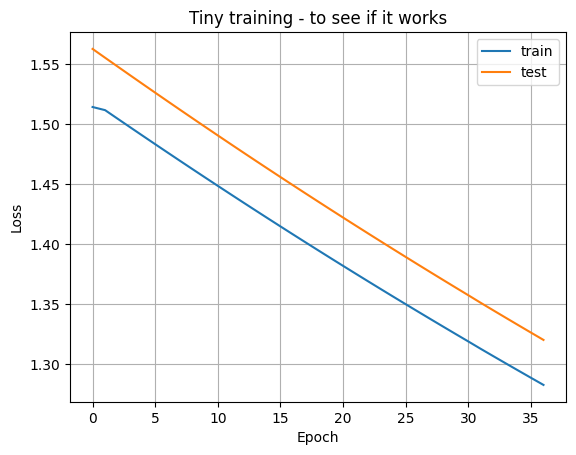

In [ ]:
df.plot(x='epoch', y=['train', 'test'], grid=True, ylabel='Loss', xlabel='Epoch',
        title='Tiny training - to see if it works');

Training seems to reduce loss, that's ok.

<div style="color: green; font-weight: bold">
Comment - Plot is uninformative because of the very few epochs. The correct solution plots the loss history but additionally analyzes how the coefficients change over time. Showing different terms of the loss in separate plots is a very good idea that gives more insight into the training process (for example, the L1 regularization term is equal to 0 when the refinement starts which is obvious when looking at their plots).
</div>

The full training that is below, is implemented for GPU, but it was not run.

First - Start by using Sequential Thresholding (ST) for training.

In [ ]:
training_params_no_ptat = default_training_params.copy()
training_params_no_ptat['use_ptat_thresholding'] = False

# sindy_autoencoder = SINDyAutoencoder(SINDy_model_params, autoencoder_hidden_dims_list)
# df = train_sindy_autoencoder(sindy_autoencoder, X_train, X_test, **training_params_no_ptat)

<div style="color: green; font-weight: bold">
Comment - not run as we did not implement GPU support. However, the commented code should work after adding GPU support.
</div>

Next - After training with ST only, enable also PTAT, train 10 models and save parameters.

In [ ]:
training_params = default_training_params.copy()

# list to store trained coefficients
trained_models = []
N_OF_MODEL_TO_TRAIN = 10

# for i in range(N_OF_MODEL_TO_TRAIN):
#     sindy_autoencoder = SINDyAutoencoder(SINDy_model_params, autoencoder_hidden_dims_list)
#     df = train_sindy_autoencoder(sindy_autoencoder, X_train, X_test, **training_params)
    # trained_models.append(sindy_autoencoder)

<div style="color: green; font-weight: bold">
Comment - not run as we did not implement GPU support. However, the commented code should work after adding GPU support.
</div>

## Task 2.7 - Evaluation & Visualization

For the sake of completing this task without having trained 10 model for 6000 epochs each, we will add a tiny bit of noise to the coefficients of the model trained for just a few epochs.

In [ ]:
coef = sindy_autoencoder.SINDy_model.coefficients.data.detach().numpy()
trained_coefficients = [
    coef + np.random.normal(0, 0.1, len(coef)) for _ in range(10)
]

trained_models = []
for coef in trained_coefficients:
    model_with_changed_coef = copy.deepcopy(sindy_autoencoder)
    model_with_changed_coef.SINDy_model.coefficients.data = torch.from_numpy(coef).float()
    trained_models.append(model_with_changed_coef)

print("First 2 trained (faked) coefficients:")
trained_models[0].SINDy_model.coefficients.data, trained_models[1].SINDy_model.coefficients.data

First 2 trained (faked) coefficients:


(tensor([1.0500, 1.1033, 1.1493, 1.0036, 0.9918, 1.1243, 1.0384, 1.1382, 0.9330,
         0.8536]),
 tensor([0.9980, 0.9929, 0.9721, 1.1283, 0.9544, 0.8352, 1.0531, 0.9339, 1.0132,
         0.9680]))

<div style="color: green; font-weight: bold">
Comment - by looking at the coefficients we can clearly see the model that was trained for just a few epochs is not good. Further analysis as well as creating 10 fake training results does little sense in this case. The correct coefficients should be similar to the ones in the correct solution, or those used during generating data: -1 * sin(x) and rest are zeros.
</div>

Below, step by step we present a comparison between the ground truth and the resimulation. The resimulation was created for a sample model in the following steps:
- generate a single sample of the pendulum data
- embed the sample to cartesian coordinates
- encode the sample using the trained autoencoder
- use the trained SINDy model to predict the derivatives of the encoded sample
- plot both ground truth and resimulated data

In [ ]:
# take sample model for the experiments
sample_model = trained_models[0]

In [ ]:
# getting sample ground truth simulation
ground_truth_simulation_params = {
    "z0_min": -np.pi,
    "z0_max": np.pi,
    "dz0_min": -2.1,
    "dz0_max": 2.1,
    "coefficients": np.array([-1.0]),
    "terms": [sin_function],
    "T": 50,
    "dt": 0.02,
    "N": 1,
    "embedding": None,
    "rejection": True,
}

ground_truth = create_pendulum_data(**ground_truth_simulation_params)[0]
ground_truth.shape

(50, 3)

<div style="color: green; font-weight: bold">
Comment - correct, creating a new ground truth simulation for resimulation purposes. Different from the ground truth solution, where a validation split of the data was simply used instead.
</div>

In [ ]:
# embed ground truth in cartesian coordinates
ground_truth_cartesian = embed_cartesian(*ground_truth.T)
ground_truth_cartesian[0].T.shape, ground_truth_cartesian[1].T.shape, ground_truth_cartesian[2].T.shape

((50, 2), (50, 2), (50, 2))

<div style="color: green; font-weight: bold">
Comment - ok, but we should use more than a single simulation, in order to compute mean of the error over time and other metrics presented in the correct solution.
</div>

In [ ]:
# encode ground truth
x = ground_truth_cartesian[0].T
dx = ground_truth_cartesian[1].T
ddx = ground_truth_cartesian[2].T
ground_truth_encoded = model.encoder(torch.from_numpy(x).float(), torch.from_numpy(dx).float(), torch.from_numpy(ddx).float())
ground_truth_encoded[0].shape, ground_truth_encoded[1].shape, ground_truth_encoded[2].shape

(torch.Size([50, 1]), torch.Size([50, 1]), torch.Size([50, 1]))

In [ ]:
# resimulate starting with the encoded cartesian ground truth 
resimulation_params = {
    "z0": ground_truth_encoded[0][0].detach().numpy()[0],
    "dz0": ground_truth_encoded[1][0].detach().numpy()[0],
    "coefficients": model.SINDy_model.coefficients.data.detach().numpy(),
    "terms": model.SINDy_model.terms,
    "T": 50,
    "dt": 0.02,
}
theta = theta
resimulation_result = simulate_pendulum(**resimulation_params)

# obtain second derivatives from resimulation with the sindy model coefficients
resimulated_ddz = model.SINDy_model(torch.from_numpy(resimulation_result[:,0]).float(), torch.from_numpy(resimulation_result[:,1]).float())
resimulation_result = np.hstack((resimulation_result, resimulated_ddz.reshape(-1,1)))
resimulation_result.shape

(50, 3)

<div style="color: green; font-weight: bold">
Comment - different than the correct solution (incorrect):

- we did not compute FVU analysis,
- we used a single simulation for the analysis instead of a whole validation split of the data,

Correct is computing the resimulation data, steps are same as in the correct solution:

- we compare the ground truth simulation with a simulation that was created in the following steps:
  - encode cartesian 2D data using the trained autoencoder's encoder
  - take the starting point of the pendulum simulation from the encoded data
  - use this starting point and sindy's model coefficients to simulate a new pendulum simulation
  - pass the new simulation results through the sindy model to get second derivatives
</div>

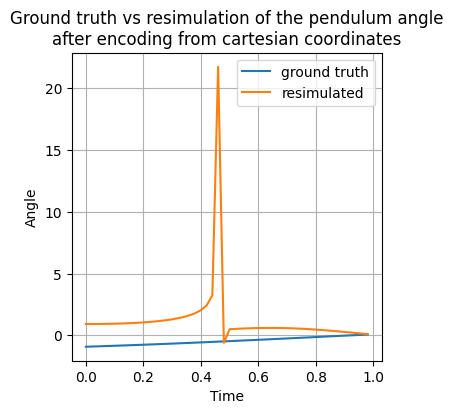

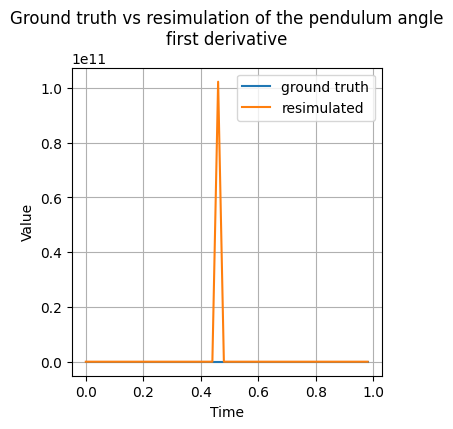

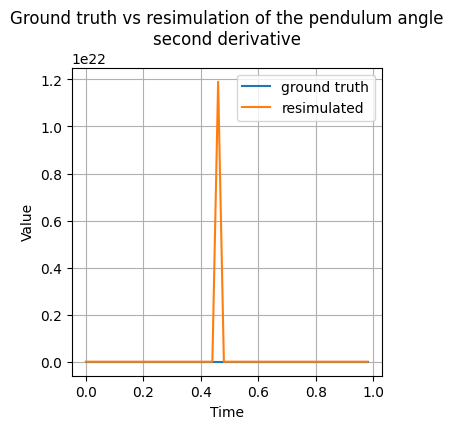

In [ ]:
# plot ground truth and resimulation
fig, ax = plt.subplots(1, 1, figsize=(4,4))
time_axis = np.arange(len(ground_truth)) * ground_truth_simulation_params['dt']
ax.plot(time_axis, ground_truth[:,0], label='ground truth')
ax.plot(time_axis, resimulation_result[:,0], label='resimulated')
ax.set_xlabel('Time')
ax.set_ylabel('Angle')
ax.grid()
plt.title('Ground truth vs resimulation of the pendulum angle\nafter encoding from cartesian coordinates')
ax.legend()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(4,4))
time_axis = np.arange(len(ground_truth)) * ground_truth_simulation_params['dt']
ax.plot(time_axis, ground_truth[:,1], label='ground truth')
ax.plot(time_axis, resimulation_result[:,1], label='resimulated')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.grid()
plt.title('Ground truth vs resimulation of the pendulum angle\nfirst derivative')
ax.legend()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(4,4))
time_axis = np.arange(len(ground_truth)) * ground_truth_simulation_params['dt']
ax.plot(time_axis, ground_truth[:,2], label='ground truth')
ax.plot(time_axis, resimulation_result[:,2], label='resimulated')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.grid()
plt.title('Ground truth vs resimulation of the pendulum angle\nsecond derivative')
ax.legend()
plt.show()

In [ ]:
print("The coefficients used for resimulation:\n(should be all zeros except for -1 at 4th position which is the sine function)")
list(model.SINDy_model.coefficients.data.detach().numpy().round(3))

The coefficients used for resimulation:
(should be all zeros except for -1 at 4th position which is the sine function)


[1.05, 1.103, 1.149, 1.004, 0.992, 1.124, 1.038, 1.138, 0.933, 0.854]

For up to t = 1 s, the resimulation should be very close to the
ground truth. In our case, for a sample model, it is not. Obtained coefficients differ from the ground truth.

<div style="color: green; font-weight: bold">
Comment - different than the correct solution (incorrect):

- we did not perform the FVU analysis (incorrect),
- correct solution contains mean error over time, we did not compute it,
- presenting coefficients is also missing from our solution.
</div>

# Task 3 - Bonus: SINDy-Autoencoder on Videos

https://arxiv.org/pdf/1904.02107.pdf, Details at page 24, Table S3 and below. Short summary at page 10, paragraph 4.3. 

This is why we chose image resolution as 51x51 pixels.

## Task 3.1 - Articial Embedding

In Section S2.3 from the paper linked in the task description, the resolution of images was 51 x 51 pixels.

In [ ]:
def embed_grid(z, t, resolution, sigma):

    # make a matrix of plot x, y coordinates
    coords = np.linspace(-1.5, 1.5, resolution)
    coords = np.array(np.meshgrid(coords, coords))

    z_transformed = np.zeros((len(z), resolution, resolution))
    for i in range(len(z)):
        # find cartesian x and y coordinates of the tip at angle z
        x = np.sin(z[i])
        y = -np.cos(z[i])
        # compute the kernel
        kernel = np.exp(-((coords[0]-x)**2 + (coords[1]-y)**2) / (2*sigma**2))
        z_transformed[i] = kernel / np.sum(kernel)

    z_transformed = torch.transpose(torch.from_numpy(z_transformed), 1, 2)

    def compute_derivatives(array, t):
        d_array = np.zeros_like(array)
        for i in range(len(array)):
            if i == 0:
                d_array[i] = (array[i+1] - array[i]) / (t[i+1] - t[i])
            elif i == len(array) - 1:
                d_array[i] = (array[i] - array[i-1]) / (t[i] - t[i-1])
            else:
                d_array[i] = (array[i+1] - array[i-1]) / (t[i+1] - t[i-1])
        return d_array
    
    # compute the first time derivatives using finite differences
    dz_transformed = compute_derivatives(z_transformed, t)

    # compute the second time derivatives using finite differences
    ddz_transformed = compute_derivatives(dz_transformed, t)
    
    return z_transformed, dz_transformed, ddz_transformed

<div style="color: green; font-weight: bold">
Comment - equivalent to the correct solution. A few lines of the code in the correct solution are too long and were cut in the pdf with the correct solution. Additionally, we computed the derivatives also for the first and last frames of the video whereas the correct solution ommited the first and last frames.
</div>

This embedding function accepts different arguments and as such, a new wrapper for creating dataset was created.

In [ ]:
# wrapper for the original data generation that applies embedding
def create_pendulum_data_new_2(z0_min, z0_max, dz0_min, dz0_max, coefficients, 
                         terms, T, dt, N, embedding=None, rejection=True):
    raw_output = create_pendulum_data(z0_min, z0_max, dz0_min, dz0_max, coefficients, 
                         terms, T, dt, N, embedding, rejection)
    # raw output: N x T x 3, where 0 is z, 1 is dz, 2 is ddz

    # we want (NxT) x 3
    output = raw_output.reshape(-1, 3)

    # apply embedding
    if embedding is not None:
        z = output[:, 0]                        # shape: N*T, only z, no dz or ddz

        t_single = np.linspace(0, T*0.02, T)
        t = np.tile(t_single, (N,1))            # shape: N x T of repeated t_single N times
        t = t.reshape(-1)                       # shape: N*T, same as z
        
        output = np.array(embedding(z, t))
        output = np.transpose(output, (1, 0, 2, 3)) # images, N*T x 3 x 51 x 51
    
    return output

<div style="color: green; font-weight: bold">
Comment - correct.
</div>

In [ ]:
# a function for plotting images at given time steps
def plot_pendulum_2d(z_transformed, dz_transformed, ddz_transformed, t, time_moments_ids_to_plot):
    fig, axs = plt.subplots(3, len(time_moments_ids_to_plot), figsize=(1.3*len(time_moments_ids_to_plot), 3.9))
    for i, time_moment_id in enumerate(time_moments_ids_to_plot):
        axs[0, i].imshow(z_transformed[time_moment_id])
        axs[0, i].set_title(f"t={t[time_moment_id]:.2f}")
        axs[1, i].imshow(dz_transformed[time_moment_id])
        axs[2, i].imshow(ddz_transformed[time_moment_id])
    axs[0, 0].set_ylabel('$x$', rotation=0, fontsize=16, labelpad=20)
    axs[1, 0].set_ylabel('$\dot{x}$', rotation=0, fontsize=16, labelpad=20)
    axs[2, 0].set_ylabel('$\ddot{x}$', rotation=0, fontsize=16, labelpad=20)

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    plt.suptitle("Pendulum's deflection angle and its derivatives, embedded in 2D", fontsize=16)
    fig.tight_layout()
    plt.show()

Parameters are same as earlier except of a difference in the embedding used.

In [ ]:
image_resolution = 51 # as in paper
points_sigma = 0.1

simulation_params = {
    "z0_min": -np.pi,
    "z0_max": np.pi,
    "dz0_min": -2.1,
    "dz0_max": 2.1,
    "coefficients": np.array([-1.0]),
    "terms": [sin_function],
    "T": 50,
    "dt": 0.02,
    "N": 100,
    "embedding": lambda z, t: embed_grid(z, t, image_resolution, points_sigma),  # <- changed
    "rejection": True,
}
simulation_data_images = create_pendulum_data_new_2(**simulation_params)

print(f"Shape of data: {simulation_data_images.shape}")

Shape of data: (5000, 3, 51, 51)


<div style="color: green; font-weight: bold">
Comment - Equivalent to the correct solution. Different is that we used the image resolution of 51 x 51 pixels instead of 50 x 50 pixels as in the correct solution.
</div>

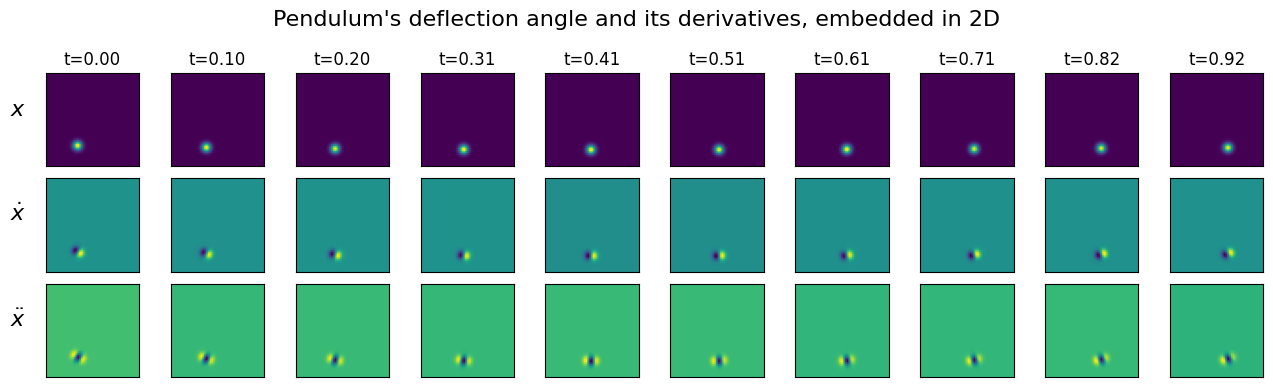

In [ ]:
N = simulation_params['N']
T = simulation_params['T']
dt = simulation_params['dt']

sim_data_images_N_T = simulation_data_images.reshape(N, T, 3, image_resolution, image_resolution)
# take: first simulation, all time steps, split into z dz ddz
x, dx, ddx = sim_data_images_N_T[0,:,0,:,:], sim_data_images_N_T[0,:,1,:,:], sim_data_images_N_T[0,:,2,:,:] 

t = np.linspace(0, dt*T, T)
time_moments_ids_to_plot=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45] # ids in experiment array

plot_pendulum_2d(x, dx, ddx, t, time_moments_ids_to_plot)

<div style="color: green; font-weight: bold">
Comment - correct, equivalent to the correct solution. Adding a title to the plot in the correct solution would improve it's readability.
</div>

## Task 3.2 - Hyperparameters

In [ ]:
# Use three hidden layers of size [128, 64, 32] for the encoder, latent dim 1, and [32, 64, 128] for the decoder
input_dim = image_resolution**2
autoencoder_hidden_dims_list = [128, 64, 32]
latent_dim = 1
SINDy_model_params = {
    "coefficients": np.ones(len(theta)),
    "mask": np.ones(len(theta)),
    "terms": theta,
}
sindy_autoencoder_model = SINDyAutoencoder(SINDy_model_params, 
                                           autoencoder_hidden_dims_list, 
                                           input_dim, latent_dim)
sindy_autoencoder_model

SINDyAutoencoder(
  (SINDy_model): SINDy()
  (encoder): CustomSequential(
    (0): LinearDerivatives(
      (linear): Linear(in_features=2601, out_features=128, bias=True)
    )
    (1): SigmoidDerivatives()
    (2): LinearDerivatives(
      (linear): Linear(in_features=128, out_features=64, bias=True)
    )
    (3): SigmoidDerivatives()
    (4): LinearDerivatives(
      (linear): Linear(in_features=64, out_features=32, bias=True)
    )
    (5): SigmoidDerivatives()
    (6): LinearDerivatives(
      (linear): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (decoder): CustomSequential(
    (0): LinearDerivatives(
      (linear): Linear(in_features=1, out_features=32, bias=True)
    )
    (1): SigmoidDerivatives()
    (2): LinearDerivatives(
      (linear): Linear(in_features=32, out_features=64, bias=True)
    )
    (3): SigmoidDerivatives()
    (4): LinearDerivatives(
      (linear): Linear(in_features=64, out_features=128, bias=True)
    )
    (5): SigmoidDerivatives()
 

<div style="color: green; font-weight: bold">
Comment - equivalent to the correct solution: sizes of the layers are the same except of the input size of 2601 instead of 2500 as in the correct solution (our images are 51x51 and the correct solution has images 50x50 pixels). This does not affect the correctness.
</div>

## Task 3.3 - Implementation & Training

In [ ]:
# flatten images (3 stands for x, dx and ddx)
simulation_data_images_flattened = simulation_data_images.reshape(N * T, 3, -1)

# split data into train and test
data_images_train, data_images_test = train_test_split(simulation_data_images_flattened,
                                                       random_state=104,  
                                                       test_size=0.2,  
                                                       shuffle=True)
data_images_train.shape, data_images_test.shape

((4000, 3, 2601), (1000, 3, 2601))

<div style="color: green; font-weight: bold">
Comment - correct, equivalent to the correct solution.
</div>

### Training
Only a few epochs as we do it without GPU support.

In [ ]:
training_params = default_training_params.copy()

# as earlier, just a proof that the training loop works and not a lengthy training
# To run full training, comment the next lines that overwrite the training params
training_params['batch_size'] = 128
training_params['training_epochs'] = 12
training_params['refinement_start_epoch'] = 10
training_params['sequential_thresholding_epochs'] = 1
training_params['ptat_patience_epochs'] = 2

df = train_sindy_autoencoder(sindy_autoencoder_model, 
                        data_images_train, data_images_test, 
                        **training_params)

Epoch 0/12: train_loss=0.0264, test_loss=0.0264
Epoch 2/12: train_loss=0.0022, test_loss=0.0016
Epoch 4/12: train_loss=0.0014, test_loss=0.0014
Epoch 6/12: train_loss=0.0014, test_loss=0.0014
Epoch 8/12: train_loss=0.0014, test_loss=0.0014
Refinement started - lambda_L0 is set to 0.
Epoch 10/12: train_loss=0.0014, test_loss=0.0014
Epoch 12/12: train_loss=0.0013, test_loss=0.0013


<div style="color: green; font-weight: bold">
Comment - similar to the correct solution but run for only a few epochs. Without GPU support the results are not informative.
</div>

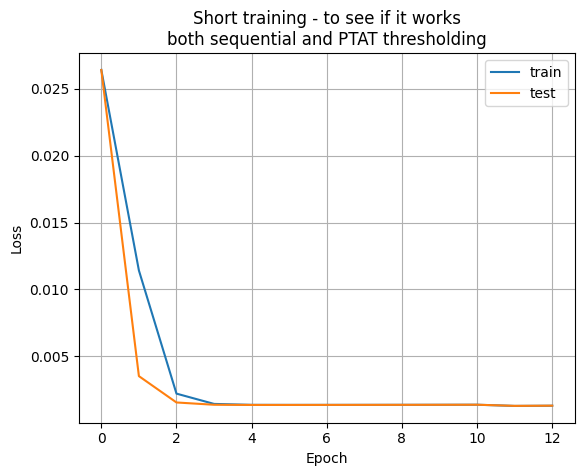

In [ ]:
df.plot(x='epoch', y=['train', 'test'], grid=True, ylabel='Loss', xlabel='Epoch',
        title='Short training - to see if it works\nboth sequential and PTAT thresholding');

Based on this plot, the training does reduce the loss.

<div style="color: green; font-weight: bold">
Comment - correct solution has many more plots that are not present in our solution.
</div>

## Task 3.4 - Evaluation

### sample code

Code below trains 2 models, one with ST and the other with PTAT thresholding. However, length of the training was greatly reduced due to lack of GPU support.

<div style="color: green; font-weight: bold">
Comment - correct solution has meaningful experiments with models that were trained with GPU (we used CPU) and for many epochs (we used only a few). We did not perform any FVU analysis or resimulation MSE over time analysis here.
</div>

In [ ]:
training_params_st = default_training_params.copy()
training_params_st['use_ptat_thresholding'] = False # use only sequential thresholding

training_params_st['batch_size'] = 128
training_params_st['training_epochs'] = 12
training_params_st['refinement_start_epoch'] = 10
training_params_st['sequential_thresholding_epochs'] = 1
# training_params_st['ptat_patience_epochs'] = 2            # ptat is disabled

sindy_autoencoder_st = SINDyAutoencoder(SINDy_model_params, 
                                           autoencoder_hidden_dims_list, 
                                           input_dim, latent_dim)
df_st = train_sindy_autoencoder(sindy_autoencoder_st, data_images_train, data_images_test, 
                        **training_params_st)

Epoch 0/12: train_loss=0.0281, test_loss=0.0281
Epoch 2/12: train_loss=0.0040, test_loss=0.0033
Epoch 4/12: train_loss=0.0030, test_loss=0.0029
Epoch 6/12: train_loss=0.0029, test_loss=0.0029
Epoch 8/12: train_loss=0.0029, test_loss=0.0029
Refinement started - lambda_L0 is set to 0.
Epoch 10/12: train_loss=0.0028, test_loss=0.0028
Epoch 12/12: train_loss=0.0027, test_loss=0.0027


In [ ]:
training_params_ptat = default_training_params.copy()
training_params_ptat['use_sequential_thresholding'] = False # use only PTAT thresholding

training_params_ptat['batch_size'] = 128
training_params_ptat['training_epochs'] = 12
training_params_ptat['refinement_start_epoch'] = 10
# training_params_ptat['sequential_thresholding_epochs'] = 1    # st is disabled
training_params_ptat['ptat_patience_epochs'] = 2

sindy_autoencoder_ptat = SINDyAutoencoder(SINDy_model_params, 
                                           autoencoder_hidden_dims_list, 
                                           input_dim, latent_dim)
df_ptat = train_sindy_autoencoder(sindy_autoencoder_ptat, data_images_train, data_images_test, 
                        **training_params_ptat)

Epoch 0/12: train_loss=0.0240, test_loss=0.0240
Epoch 2/12: train_loss=0.0011, test_loss=0.0004
Epoch 4/12: train_loss=0.0002, test_loss=0.0002
Epoch 6/12: train_loss=0.0002, test_loss=0.0002
Epoch 8/12: train_loss=0.0002, test_loss=0.0002
Refinement started - lambda_L0 is set to 0.
Epoch 10/12: train_loss=0.0002, test_loss=0.0002
Epoch 12/12: train_loss=0.0001, test_loss=0.0001


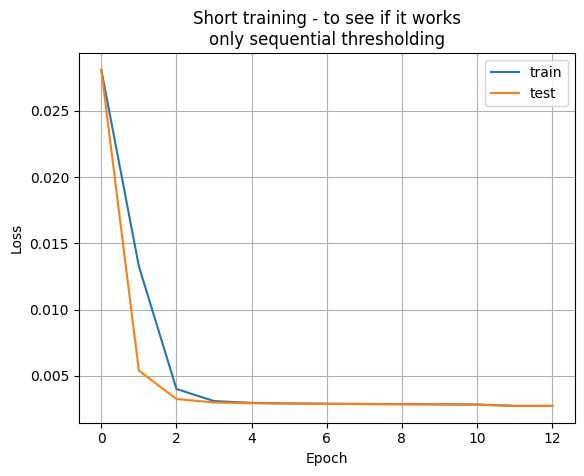

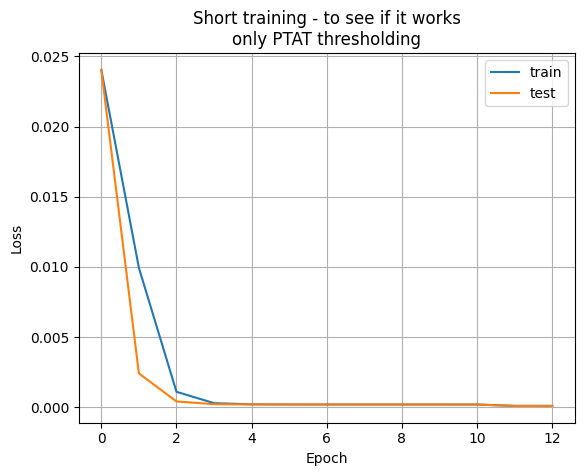

In [ ]:
df_st.plot(x='epoch', y=['train', 'test'], grid=True, ylabel='Loss', xlabel='Epoch',
        title='Short training - to see if it works\nonly sequential thresholding')
plt.show()
df_ptat.plot(x='epoch', y=['train', 'test'], grid=True, ylabel='Loss', xlabel='Epoch',
        title='Short training - to see if it works\nonly PTAT thresholding')
plt.show()

<div style="color: green; font-weight: bold">
Comment - Plots present strangly low loss, but looking at the correct solution, loss of their models also presented some strange behaviour.
</div>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fec51f31-bfa7-40ee-8529-68c58f0647eb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>